# FLoC Cohorts from sessions panel data



In [143]:
from datetime import datetime
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import floc

from data import read_weeks_machines_domains
import prefixLSH


read in pre-processed sessions data

In [145]:
# read in the pre-processed sessions data 
# this maps week,machine_id -> domains set
weeks_machines_domains_fpath = '../output/weeks_machines_domains.csv'
weeks_machines_domains_df = read_weeks_machines_domains(weeks_machines_domains_fpath)
weeks_machines_domains_df.drop(['machine_id', 'domains'], axis=1).head()

reading from ../output/weeks_machines_domains.csv...
... read 4877236 rows


,week,n_domains
0,1,104
1,1,0
2,1,20
3,1,49
4,1,64


___

read in panels that were created based on the sessions data and demographic data

attach domains data

attach the simhash computed from the domains

precompute cohorts for each panel

In [5]:
all_panels_fpath = '../output/all_panels.csv'
all_panels_df = pd.read_csv(all_panels_fpath)
print('read in all panels: %s total rows' % len(all_panels_df))
print('%s panels' % all_panels_df.panel_id.nunique())
all_panels_df.drop(['machine_id'], axis=1).head()

read in all panels: 3302090 total rows
520 panels


,week,n_domains,household_income,racial_background,stratify,panel_id
0,1,40,1.0,1.0,"1.0, 1.0",1
1,1,43,1.0,1.0,"1.0, 1.0",1
2,1,147,1.0,1.0,"1.0, 1.0",1
3,1,45,1.0,1.0,"1.0, 1.0",1
4,1,22,1.0,1.0,"1.0, 1.0",1


In [6]:
weeks_machines_domains = weeks_machines_domains_df.set_index(['machine_id','week'])['domains']
all_panels_df['domains'] = all_panels_df.set_index(['machine_id','week']).index.map(weeks_machines_domains)
all_panels_df.drop(['machine_id','domains'], axis=1).head()

,week,n_domains,household_income,racial_background,stratify,panel_id
0,1,40,1.0,1.0,"1.0, 1.0",1
1,1,43,1.0,1.0,"1.0, 1.0",1
2,1,147,1.0,1.0,"1.0, 1.0",1
3,1,45,1.0,1.0,"1.0, 1.0",1
4,1,22,1.0,1.0,"1.0, 1.0",1


In [7]:
# apply simhash
all_panels_df['simhash'] = all_panels_df.domains.apply(floc.hashes.sim_hash_string)

Save intermediary output: panels with simhash

In [8]:
all_panels_simhash_fpath = '../output/all_panels_simhash.csv'

In [10]:
print('saving to %s...' % all_panels_simhash_fpath)
all_panels_df.drop('domains', axis=1).to_csv(all_panels_simhash_fpath, index=False)

saving to ../output/all_panels_simhash.csv...


script re-entry point

In [11]:
all_panels_df = pd.read_csv(all_panels_simhash_fpath)
print('read in all panels: %s total rows' % len(all_panels_df))
print('%s panels' % all_panels_df.panel_id.nunique())
all_panels_df.head()

read in all panels: 3302090 total rows
520 panels


,machine_id,week,n_domains,household_income,racial_background,stratify,panel_id,simhash
0,225477651,1,40,1.0,1.0,"1.0, 1.0",1,1053512748232354
1,215623532,1,43,1.0,1.0,"1.0, 1.0",1,207270634237270
2,186655210,1,147,1.0,1.0,"1.0, 1.0",1,155255686110552
3,224752776,1,45,1.0,1.0,"1.0, 1.0",1,765518950719653
4,207687017,1,22,1.0,1.0,"1.0, 1.0",1,1087583118580527


##### Pre-compute cohorts for each panel

each sample's cohort is dependent on the rest of the simhashes in the panel

for this reason, cohorts must be computed per panel

below using k = 40

In [32]:
# TODO: repeat this analysis with another min_k for a robustness test
# e.g. all_panels_cohorts80_df = all_panels_df.copy(); min_k=80
min_k = 40 
# preset all cohorts to None
# cohort_k40 = 'cohort_k40'
all_panels_df['cohort'] = np.nan

for panel_id in all_panels_df.panel_id.unique():
    t_start = datetime.now()
    if panel_id % 1 == 0:
        print('computing cohorts for panel %s/%s' % (panel_id, all_panels_df.panel_id.nunique()))
    panel_df = all_panels_df[all_panels_cohorts_df.panel_id==panel_id]
    cohorts_dict = prefixLSH.get_cohorts_dict(panel_df.simhash.astype(int), min_k=min_k)
    assign_cohort = lambda x: cohorts_dict[x.simhash] if x.panel_id == panel_id else x['cohort']
    all_panels_df['cohort'] = all_panels_df.apply(assign_cohort, axis=1)
    if panel_id % 1 == 0:
        print('took %s' % (datetime.now() - t_start))

computing cohorts for panel 1/520
took 0:00:52.600540
computing cohorts for panel 2/520
took 0:00:51.353196
computing cohorts for panel 3/520
took 0:00:50.400729
computing cohorts for panel 4/520
took 0:00:50.253033
computing cohorts for panel 5/520
took 0:00:48.421979
computing cohorts for panel 6/520
took 0:00:48.979739
computing cohorts for panel 7/520
took 0:00:49.001481
computing cohorts for panel 8/520
took 0:00:48.793433
computing cohorts for panel 9/520
took 0:00:50.414048
computing cohorts for panel 10/520
took 0:00:54.387241
computing cohorts for panel 11/520
took 0:00:46.691973
computing cohorts for panel 12/520
took 0:00:47.792375
computing cohorts for panel 13/520
took 0:00:48.431833
computing cohorts for panel 14/520
took 0:00:48.221698
computing cohorts for panel 15/520
took 0:00:49.071599
computing cohorts for panel 16/520
took 0:00:49.839058
computing cohorts for panel 17/520
took 0:00:46.861759
computing cohorts for panel 18/520
took 0:00:49.454528
computing cohorts f

took 0:00:45.830074
computing cohorts for panel 150/520
took 0:00:45.614102
computing cohorts for panel 151/520
took 0:00:45.410041
computing cohorts for panel 152/520
took 0:00:45.330386
computing cohorts for panel 153/520
took 0:00:45.208685
computing cohorts for panel 154/520
took 0:00:45.732036
computing cohorts for panel 155/520
took 0:00:45.415627
computing cohorts for panel 156/520
took 0:00:45.261943
computing cohorts for panel 157/520
took 0:00:45.392096
computing cohorts for panel 158/520
took 0:00:45.663109
computing cohorts for panel 159/520
took 0:00:45.461220
computing cohorts for panel 160/520
took 0:00:45.262960
computing cohorts for panel 161/520
took 0:00:45.716153
computing cohorts for panel 162/520
took 0:00:45.264270
computing cohorts for panel 163/520
took 0:00:45.299992
computing cohorts for panel 164/520
took 0:00:45.411671
computing cohorts for panel 165/520
took 0:00:45.246869
computing cohorts for panel 166/520
took 0:00:45.173287
computing cohorts for panel 

took 0:00:45.190597
computing cohorts for panel 297/520
took 0:00:45.657472
computing cohorts for panel 298/520
took 0:00:45.643105
computing cohorts for panel 299/520
took 0:00:46.037725
computing cohorts for panel 300/520
took 0:00:45.405885
computing cohorts for panel 301/520
took 0:00:45.601770
computing cohorts for panel 302/520
took 0:00:45.315753
computing cohorts for panel 303/520
took 0:00:45.565963
computing cohorts for panel 304/520
took 0:00:45.192717
computing cohorts for panel 305/520
took 0:00:45.689886
computing cohorts for panel 306/520
took 0:00:45.553669
computing cohorts for panel 307/520
took 0:00:45.336463
computing cohorts for panel 308/520
took 0:00:45.151046
computing cohorts for panel 309/520
took 0:00:45.537185
computing cohorts for panel 310/520
took 0:00:45.341036
computing cohorts for panel 311/520
took 0:00:45.364670
computing cohorts for panel 312/520
took 0:00:45.678511
computing cohorts for panel 313/520
took 0:00:45.445915
computing cohorts for panel 

took 0:00:45.282123
computing cohorts for panel 444/520
took 0:00:45.671957
computing cohorts for panel 445/520
took 0:00:45.649368
computing cohorts for panel 446/520
took 0:00:45.025692
computing cohorts for panel 447/520
took 0:00:45.469281
computing cohorts for panel 448/520
took 0:00:45.023853
computing cohorts for panel 449/520
took 0:00:45.579217
computing cohorts for panel 450/520
took 0:00:45.348603
computing cohorts for panel 451/520
took 0:00:45.885394
computing cohorts for panel 452/520
took 0:00:45.278543
computing cohorts for panel 453/520
took 0:00:45.512815
computing cohorts for panel 454/520
took 0:00:45.621335
computing cohorts for panel 455/520
took 0:00:45.349368
computing cohorts for panel 456/520
took 0:00:45.326544
computing cohorts for panel 457/520
took 0:00:45.562885
computing cohorts for panel 458/520
took 0:00:45.245208
computing cohorts for panel 459/520
took 0:00:45.755102
computing cohorts for panel 460/520
took 0:00:45.365361
computing cohorts for panel 

In [33]:
all_panels_df.head(3) 

,machine_id,week,n_domains,household_income,racial_background,stratify,panel_id,simhash,cohort
0,225477651,1,40,1.0,1.0,"1.0, 1.0",1,1053512748232354,107.0
1,215623532,1,43,1.0,1.0,"1.0, 1.0",1,207270634237270,20.0
2,186655210,1,147,1.0,1.0,"1.0, 1.0",1,155255686110552,14.0


save intermediary output

In [35]:
all_panels_cohorts_fpath = '../output/all_panels_cohorts.csv'

In [36]:
print('saving to %s...' % all_panels_cohorts_fpath)
all_panels_df.to_csv(all_panels_cohorts_fpath, index=False)

saving to ../output/all_panels_cohorts.csv...


script re-entry point

In [24]:
all_panels_df = pd.read_csv(all_panels_cohorts_fpath)
print('read in all panels: %s total rows' % len(all_panels_df))
print('%s panels' % all_panels_df.panel_id.nunique())
all_panels_df.head()

read in all panels: 3302090 total rows
520 panels


,machine_id,week,n_domains,household_income,racial_background,stratify,panel_id,simhash,cohort
0,225477651,1,40,1.0,1.0,"1.0, 1.0",1,1053512748232354,107.0
1,215623532,1,43,1.0,1.0,"1.0, 1.0",1,207270634237270,20.0
2,186655210,1,147,1.0,1.0,"1.0, 1.0",1,155255686110552,14.0
3,224752776,1,45,1.0,1.0,"1.0, 1.0",1,765518950719653,74.0
4,207687017,1,22,1.0,1.0,"1.0, 1.0",1,1087583118580527,110.0


In [25]:
# get just one panel for now

cohort sizes:
count    112.000000
mean      59.482143
std       14.196169
min       40.000000
25%       47.000000
50%       55.500000
75%       71.000000
max       95.000000
Name: cohort, dtype: float64


,machine_id,week,n_domains,household_income,racial_background,stratify,panel_id,simhash,cohort
0,225477651,1,40,1.0,1.0,"1.0, 1.0",1,1053512748232354,107.0
1,215623532,1,43,1.0,1.0,"1.0, 1.0",1,207270634237270,20.0
2,186655210,1,147,1.0,1.0,"1.0, 1.0",1,155255686110552,14.0


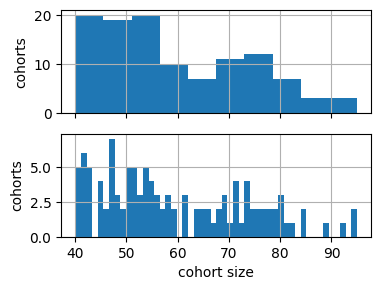

In [29]:
panel_df1 = all_panels_df[all_panels_df.panel_id == 1]
print('cohort sizes:')
cohort_counts = panel_df1['cohort'].value_counts()
print(cohort_counts.describe())

fig,ax = plt.subplots(2,1,figsize=(4,3), sharex=True, dpi=100)
cohort_counts.hist(ax=ax[0])
ax[0].set_ylabel('cohorts')
ax[1].set_ylabel('cohorts')
_ = ax[1].set_xlabel('cohort size')
_ = cohort_counts.hist(ax=ax[1], bins=50)
panel_df1.head(3)

In [135]:
panel_id = random.choice(all_panels_df.panel_id.unique())
print('using random panel id: %s' % panel_id)
panel_df = all_panels_df[all_panels_df.panel_id == panel_id].copy()
panel_df.head(3)

using random panel id: 378


,machine_id,week,n_domains,household_income,racial_background,stratify,panel_id,simhash,cohort
2400059,205523982,14,58,1.0,1.0,"1.0, 1.0",378,1043345175183993,103.0
2400060,211871580,14,51,1.0,1.0,"1.0, 1.0",378,328558430596107,28.0
2400061,176902903,14,16,1.0,1.0,"1.0, 1.0",378,604114564613681,50.0


cohort sizes:
count    112.000000
mean      60.285714
std       13.923490
min       40.000000
25%       49.000000
50%       59.000000
75%       69.000000
max      101.000000
Name: cohort, dtype: float64


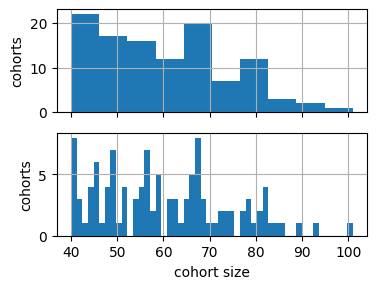

In [136]:
print('cohort sizes:')

cohort_counts = panel_df["cohort"].value_counts()
print(cohort_counts.describe())

fig,ax = plt.subplots(2,1,figsize=(4,3), sharex=True, dpi=100)
cohort_counts.hist(ax=ax[0])
ax[0].set_ylabel('cohorts')
ax[1].set_ylabel('cohorts')
_ = ax[1].set_xlabel('cohort size')
_ = cohort_counts.hist(ax=ax[1], bins=50)

In [137]:
def get_cohort_demo_portions_df(panel_df, demo_col):
    df = panel_df.groupby(
        ['cohort', demo_col]
    ).count()['panel_id'].rename('count').to_frame().reset_index(demo_col)
    df['total'] = panel_df.groupby('cohort').count()['panel_id']
    df['portion'] = df['count']/df['total']
    return df

In [138]:
import math

dpi = 100
t = 0.1

def plot_cohort_demo_fractions(panel_df, demo_col, demo_value_names_dict, 
                               ncols=4, suptitle='', print=False):
    
    nrows = math.ceil(len(demo_value_names_dict)/ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), dpi=dpi)
    axes = axes.flatten()
    axes[0].set_ylabel('fraction')
    fig.tight_layout()
    fig.suptitle(suptitle)

    cohort_demo_portions_df = get_cohort_demo_portions_df(panel_df, demo_col)
    demo_fractions = panel_df.groupby(demo_col)['panel_id'].count() / len(panel_df)
    
    for i, (val,name) in enumerate(demo_value_names_dict.items()):
        ax = axes[i]
        cohort_demo_mean = cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.mean()
        # Google's sensitivity analysis actually looked at avg for sensitive categories
        # across all users rather than across cohorts
        demo_fraction = demo_fractions[val]
        if print:
            print('mean fraction %s across cohorts = %0.2f' % (name, cohort_demo_mean))
            print('fraction %s across all users in cohorts = %0.2f' % (name, demo_fraction))
        cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.sort_values(ascending=False).plot.bar(ax=ax, label="")
        ax.hlines(y=demo_fraction, xmin=0, xmax=len(ax.get_xticks()), 
                  linestyles='-', color='black', label='mean')
        if (demo_fraction - t) > 0:
            ax.hlines(y=demo_fraction-t, xmin=0, xmax=len(ax.get_xticks()), 
                      linestyles='--', color='black', label='mean - t=0.1')
        ax.hlines(y=demo_fraction+t, xmin=0, xmax=len(ax.get_xticks()), 
                  linestyles='--', color='black', label='mean + t=0.1')
        ax.set_xticks([])
        ax.set_xlabel('cohorts')
        #ax.set_ylabel('fraction "%s"' % name)
        ax.set_title(name)
    plt.show()
    return cohort_demo_portions_df

In [139]:
race_values = {1:'white', 2:'black', 3:'asian', 5:'other'}
hi_values = {1:'0 to 25k', 2:'25k to 50k', 3:'50k to 100k', 4:'100k +'}
hi_race_values = {
    "1.0, 1.0": "0 to 25k, white",
    "2.0, 1.0": "25k to 50k, white",
    "3.0, 1.0": "50k to 100k, white",
    "4.0, 1.0": "100k +, white",
    
    "1.0, 2.0": "0 to 25k, black",
    "2.0, 2.0": "25k to 50k, black",
    "3.0, 2.0": "50k to 100k, black",
    "4.0, 2.0": "100k +, black",
    
    "1.0, 3.0": "0 to 25k, asian",
    "2.0, 3.0": "25k to 50k, asian",
    "3.0, 3.0": "50k to 100k, asian",
    "4.0, 3.0": "100k +, asian",
    
    "1.0, 5.0": "0 to 25k, other",
    "2.0, 5.0": "25k to 50k, other",
    "3.0, 5.0": "50k to 100k, other",
    "4.0, 5.0": "100k +, other",
}

Looking at race

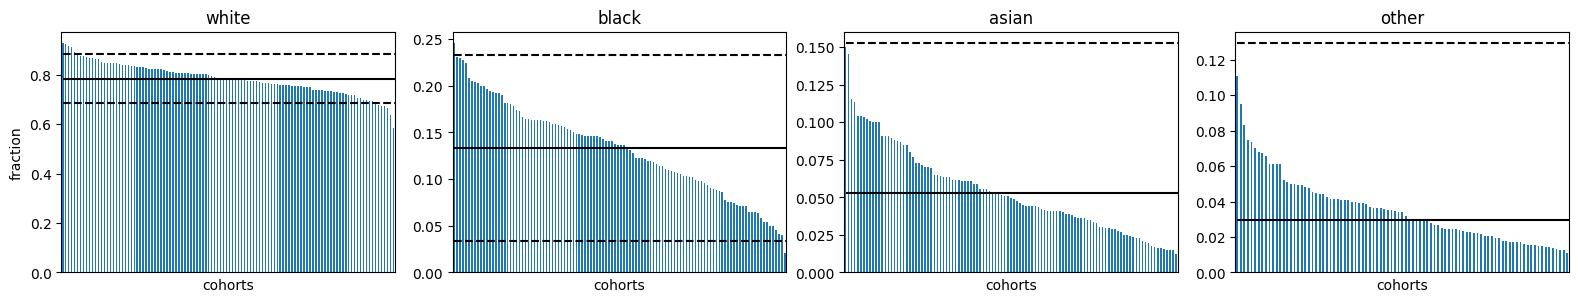

,racial_background,count,total,portion
cohort,,,,
1.0,1.0,58,66,0.878788
1.0,2.0,3,66,0.045455
1.0,3.0,4,66,0.060606
1.0,5.0,1,66,0.015152
2.0,1.0,53,63,0.841270


In [140]:
race = plot_cohort_demo_fractions(panel_df, 'racial_background', race_values)
race.head()

Looking at just household income

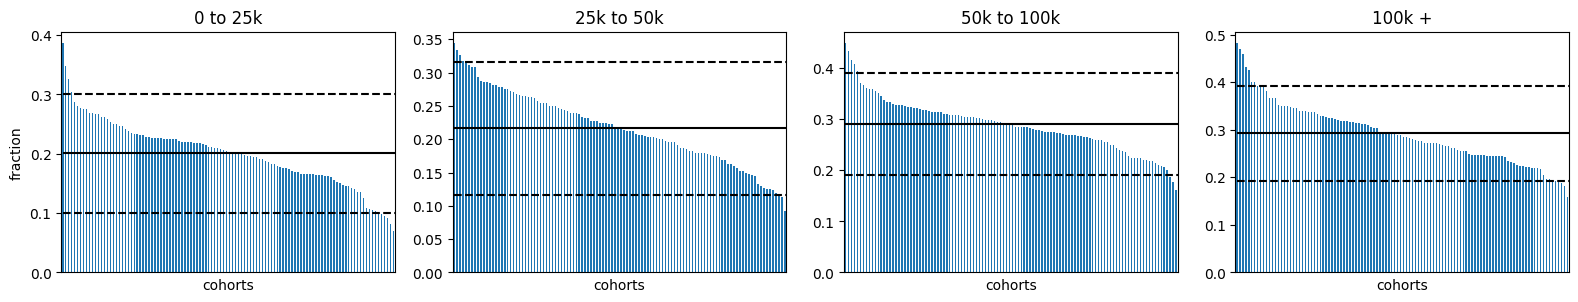

,household_income,count,total,portion
cohort,,,,
1.0,1.0,16,66,0.242424
1.0,2.0,14,66,0.212121
1.0,3.0,18,66,0.272727
1.0,4.0,18,66,0.272727
2.0,1.0,13,63,0.206349


In [141]:
hi = plot_cohort_demo_fractions(panel_df, 'household_income', hi_values)
hi.head()

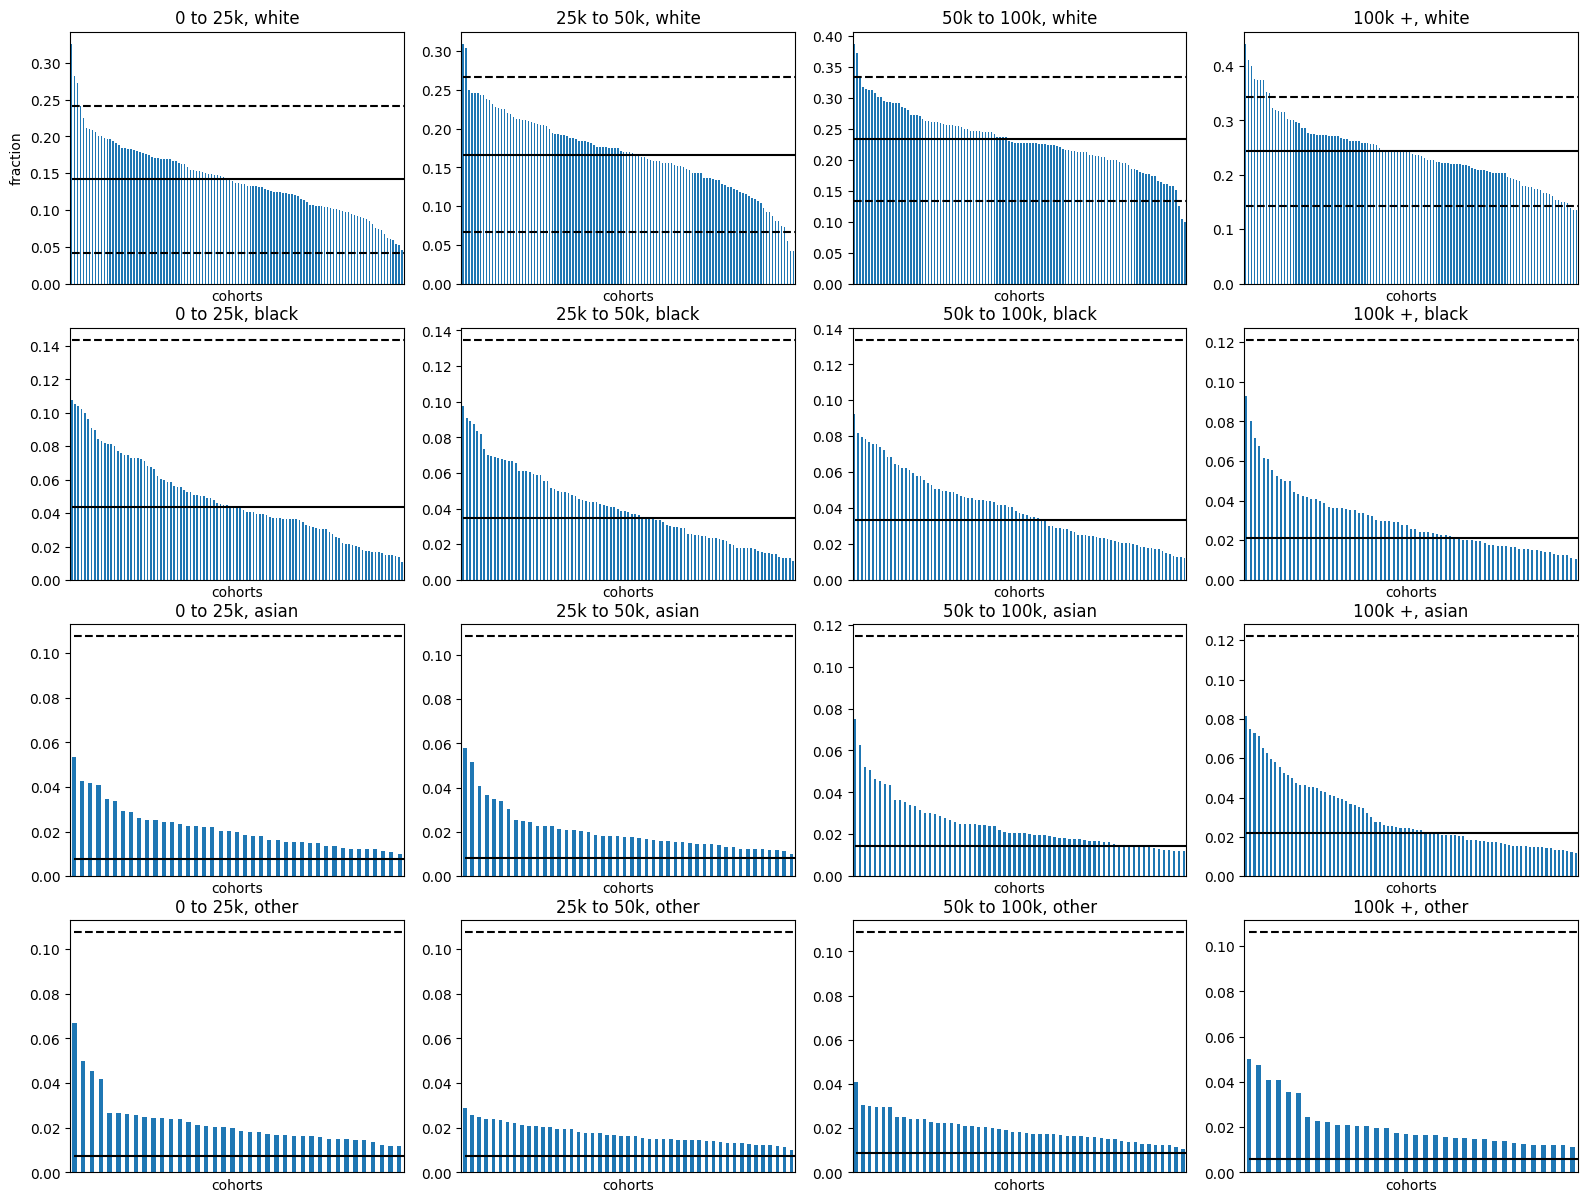

,stratify,count,total,portion
cohort,,,,
1.0,"1.0, 1.0",14,66,0.212121
1.0,"1.0, 2.0",1,66,0.015152
1.0,"1.0, 3.0",1,66,0.015152
1.0,"2.0, 1.0",12,66,0.181818
1.0,"2.0, 2.0",1,66,0.015152
...,...,...,...,...
112.0,"3.0, 3.0",1,57,0.017544
112.0,"3.0, 5.0",1,57,0.017544
112.0,"4.0, 1.0",15,57,0.263158


In [142]:
hi_race = plot_cohort_demo_fractions(panel_df, 'stratify', hi_race_values)
hi_race

### Analyzing differences across different values of k

In [41]:
all_panels_df.head(3)

,machine_id,week,n_domains,household_income,racial_background,stratify,panel_id,simhash,cohort
0,225477651,1,40,1.0,1.0,"1.0, 1.0",1,1053512748232354,107.0
1,215623532,1,43,1.0,1.0,"1.0, 1.0",1,207270634237270,20.0
2,186655210,1,147,1.0,1.0,"1.0, 1.0",1,155255686110552,14.0


In [128]:
panel_id = 1
panel_df = all_panels_df[all_panels_df.panel_id==panel_id].copy()
print('using panel id %s' % panel_id)
panel_df.head(3)

using panel id 1


,machine_id,week,n_domains,household_income,racial_background,stratify,panel_id,simhash,cohort
0,225477651,1,40,1.0,1.0,"1.0, 1.0",1,1053512748232354,107.0
1,215623532,1,43,1.0,1.0,"1.0, 1.0",1,207270634237270,20.0
2,186655210,1,147,1.0,1.0,"1.0, 1.0",1,155255686110552,14.0



k=20 ---------------------------

205 total cohorts


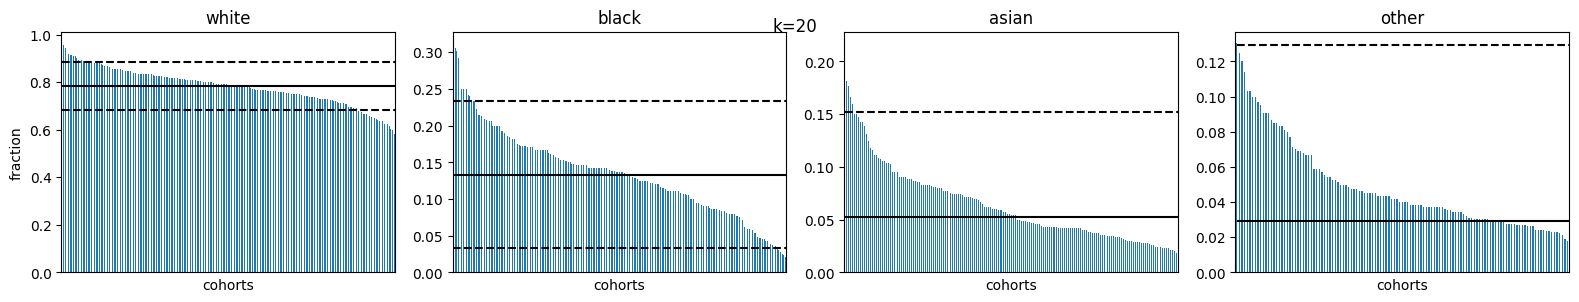

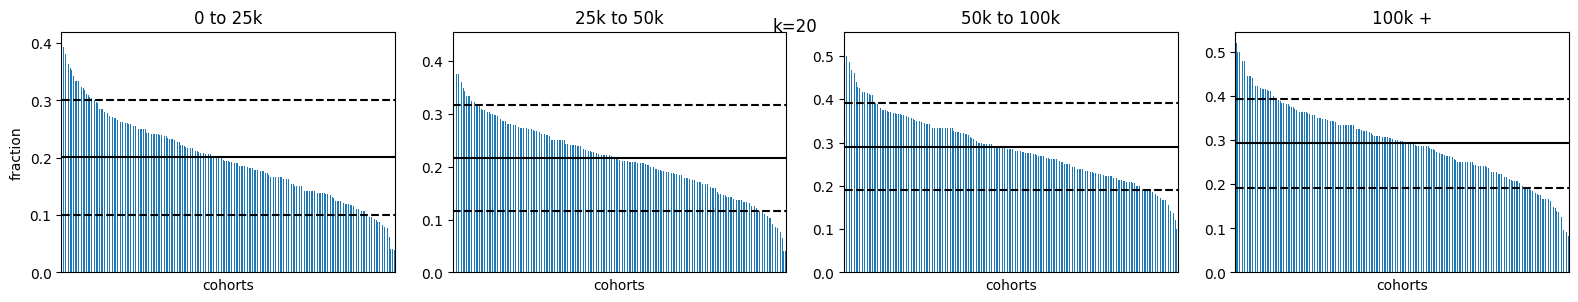

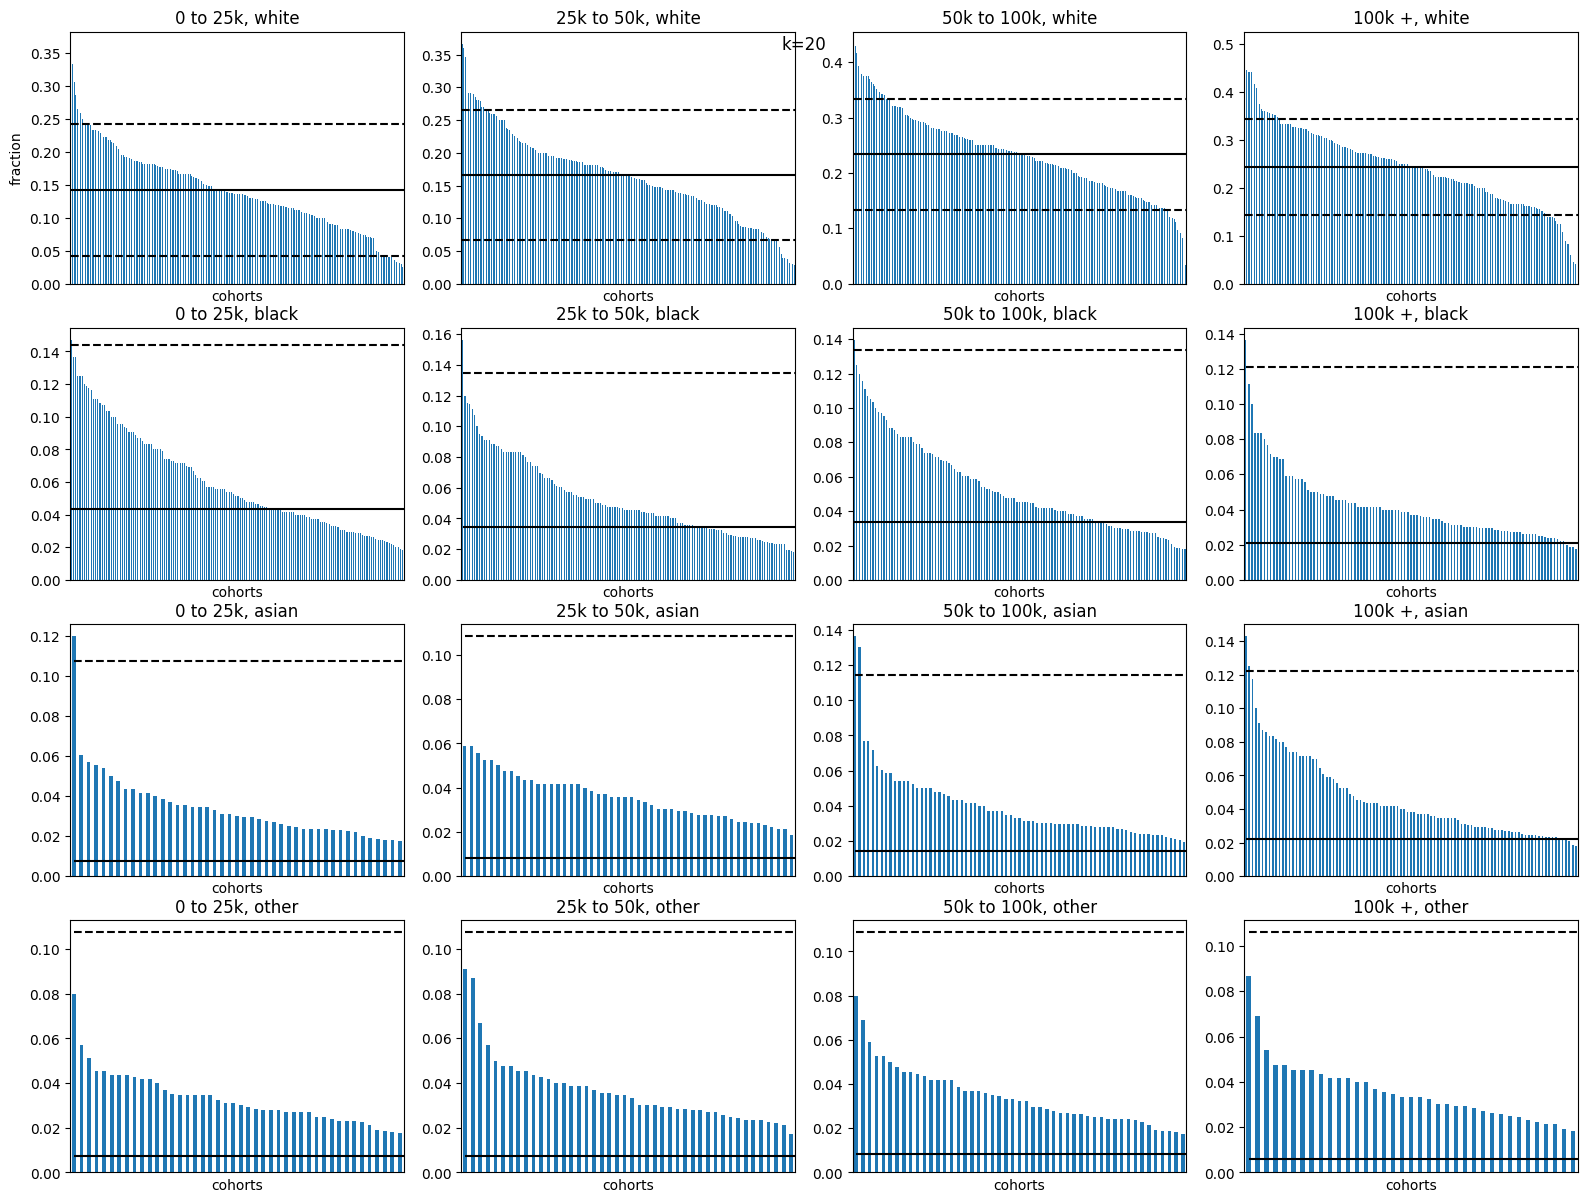


k=30 ---------------------------

144 total cohorts


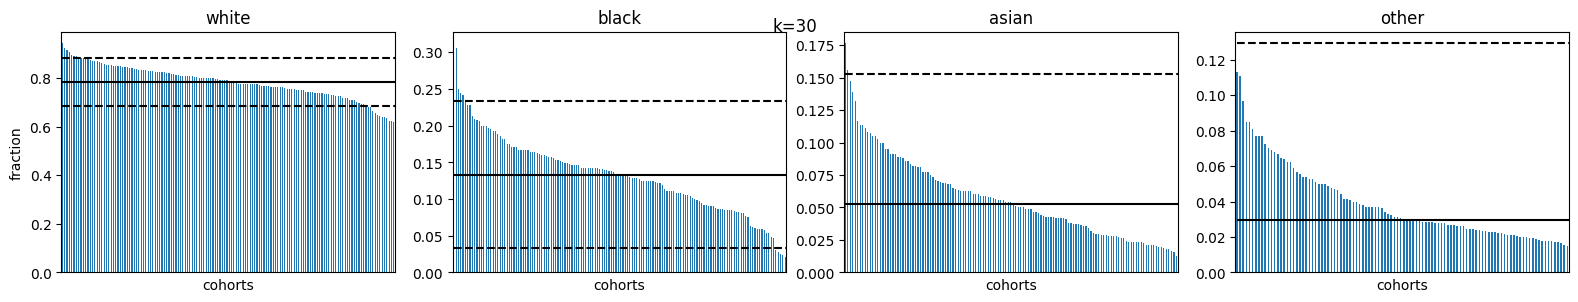

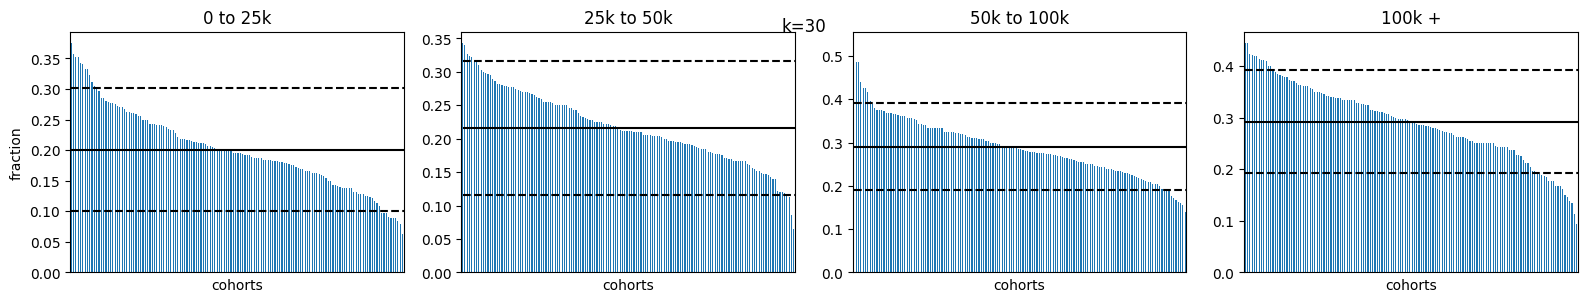

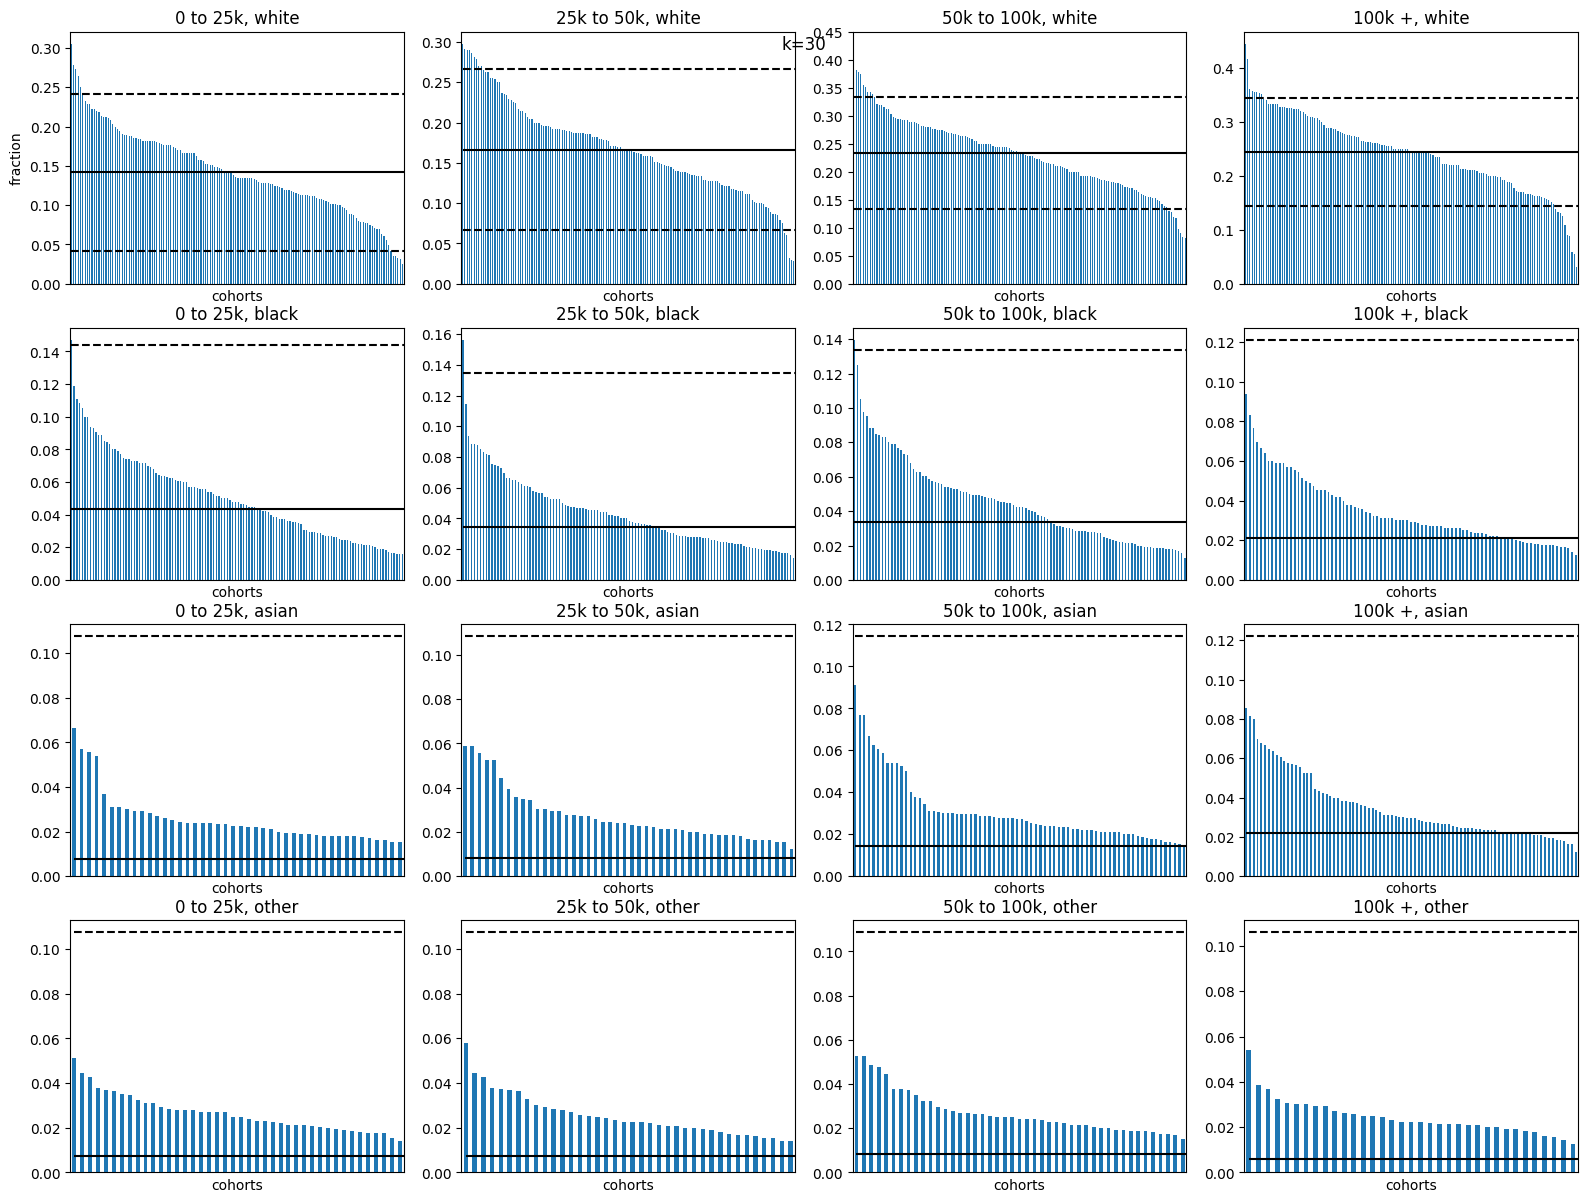


k=40 ---------------------------

112 total cohorts


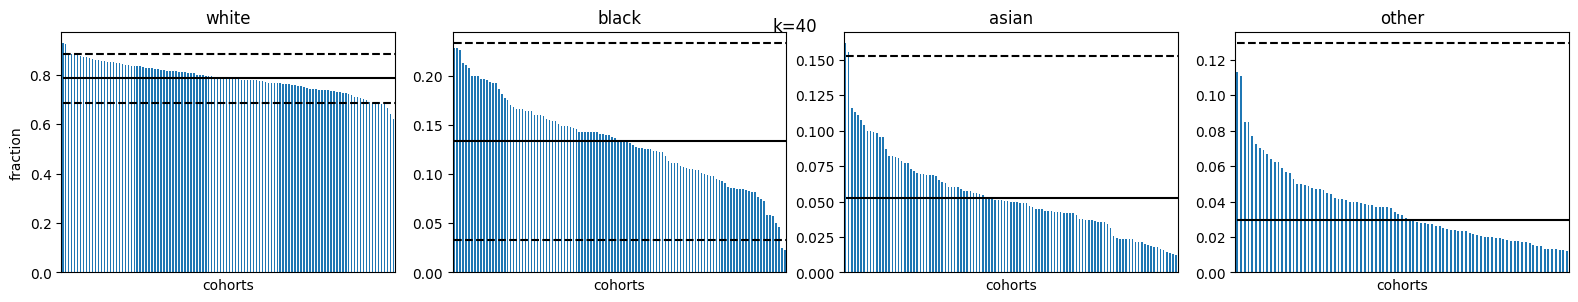

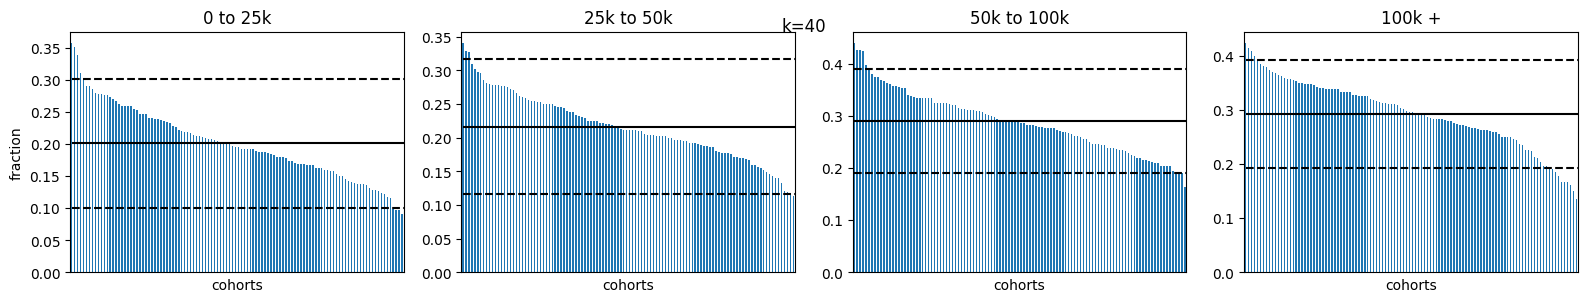

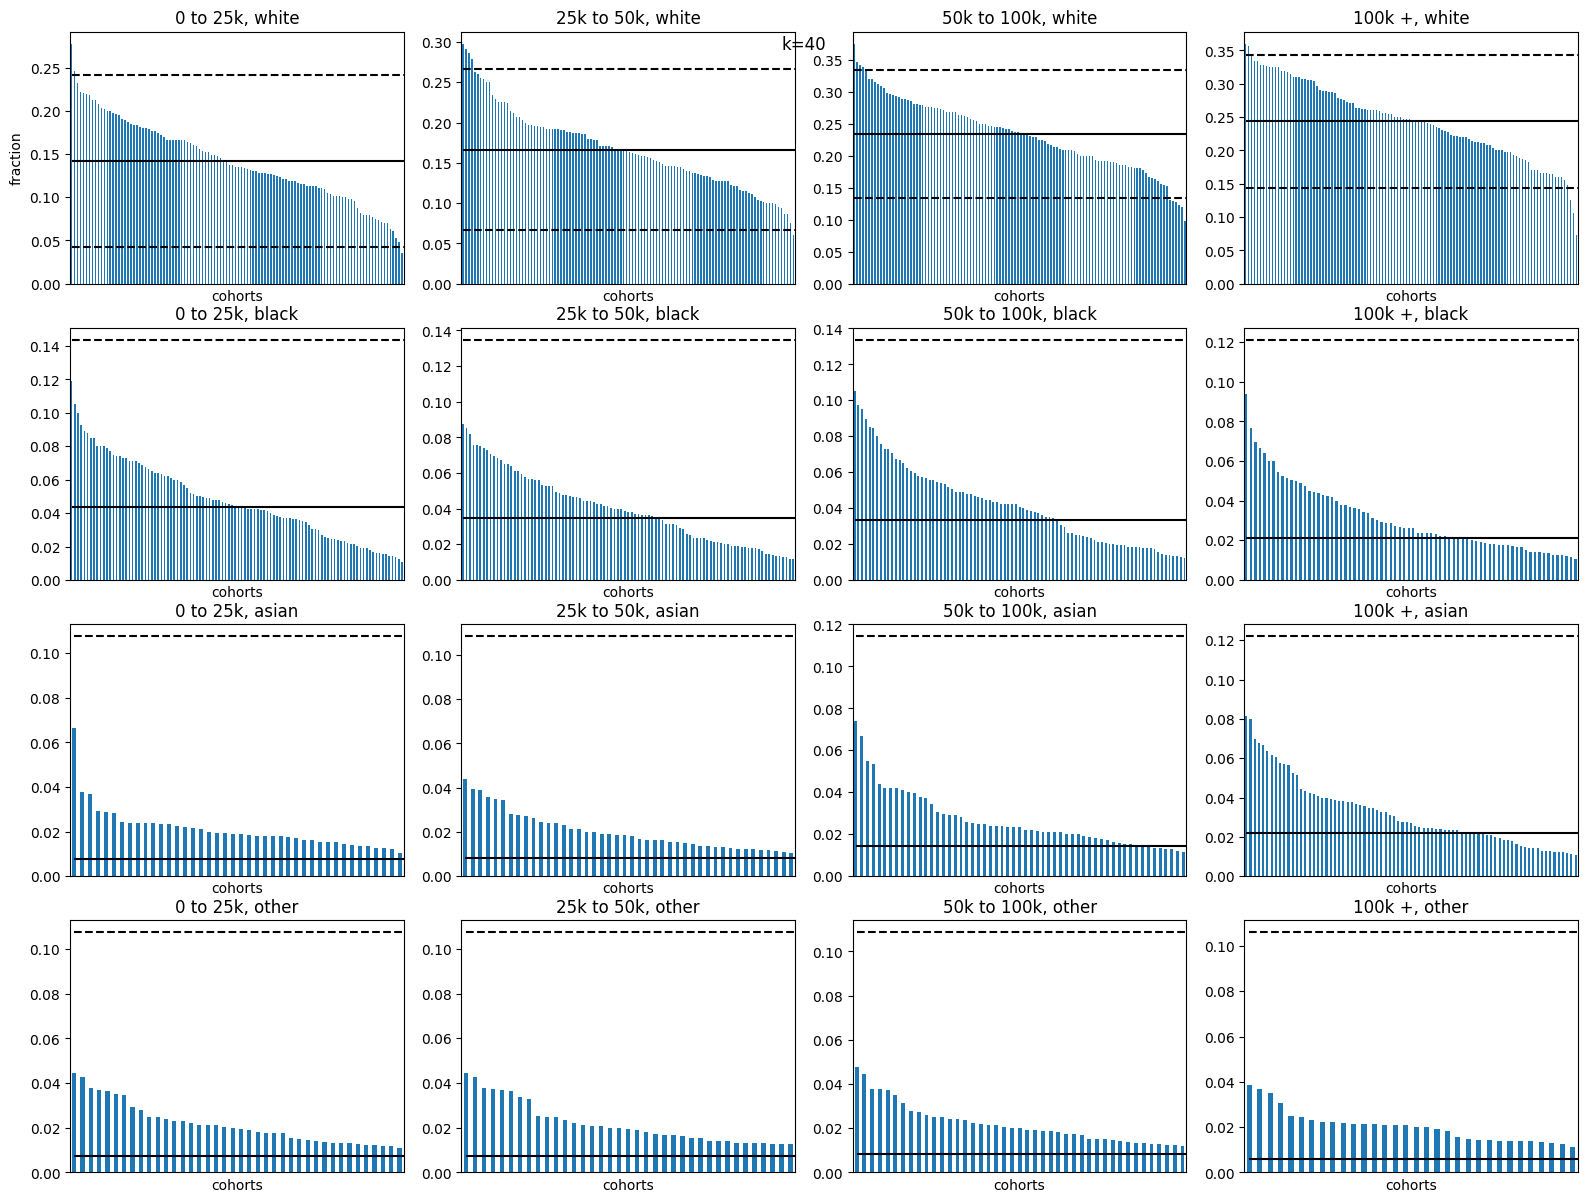


k=50 ---------------------------

88 total cohorts


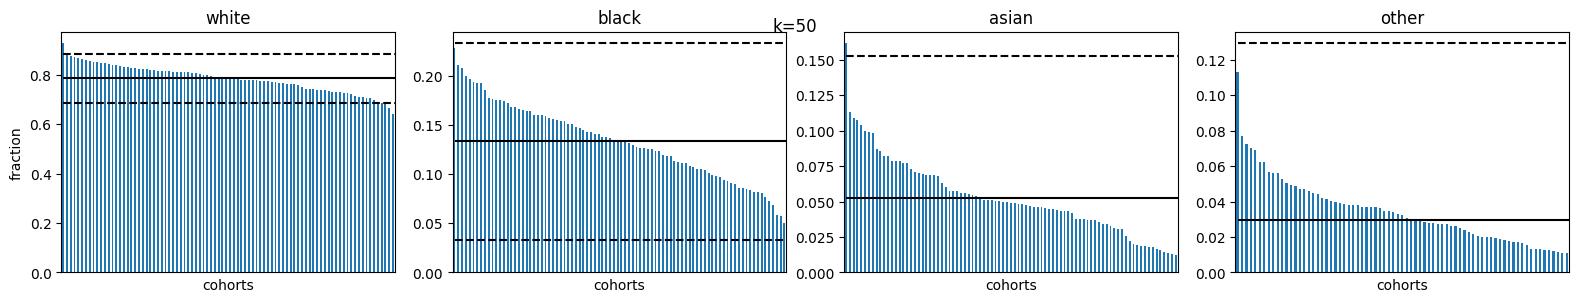

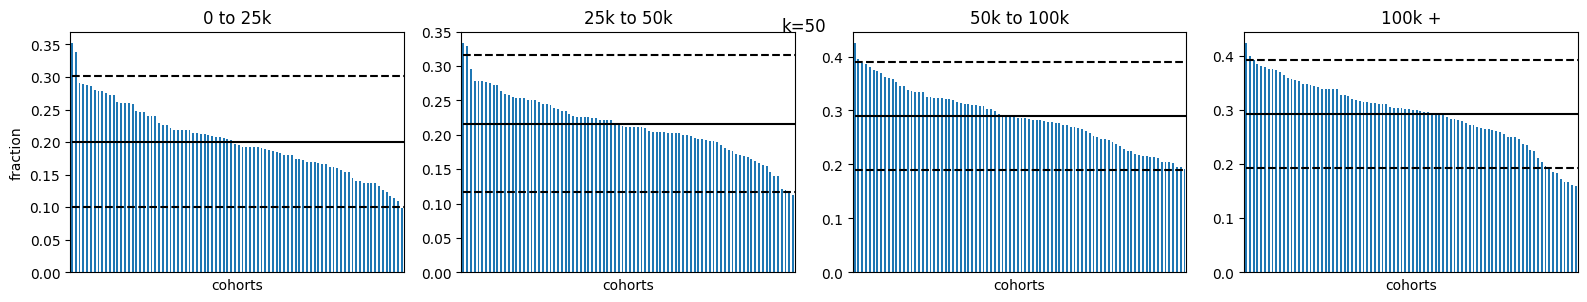

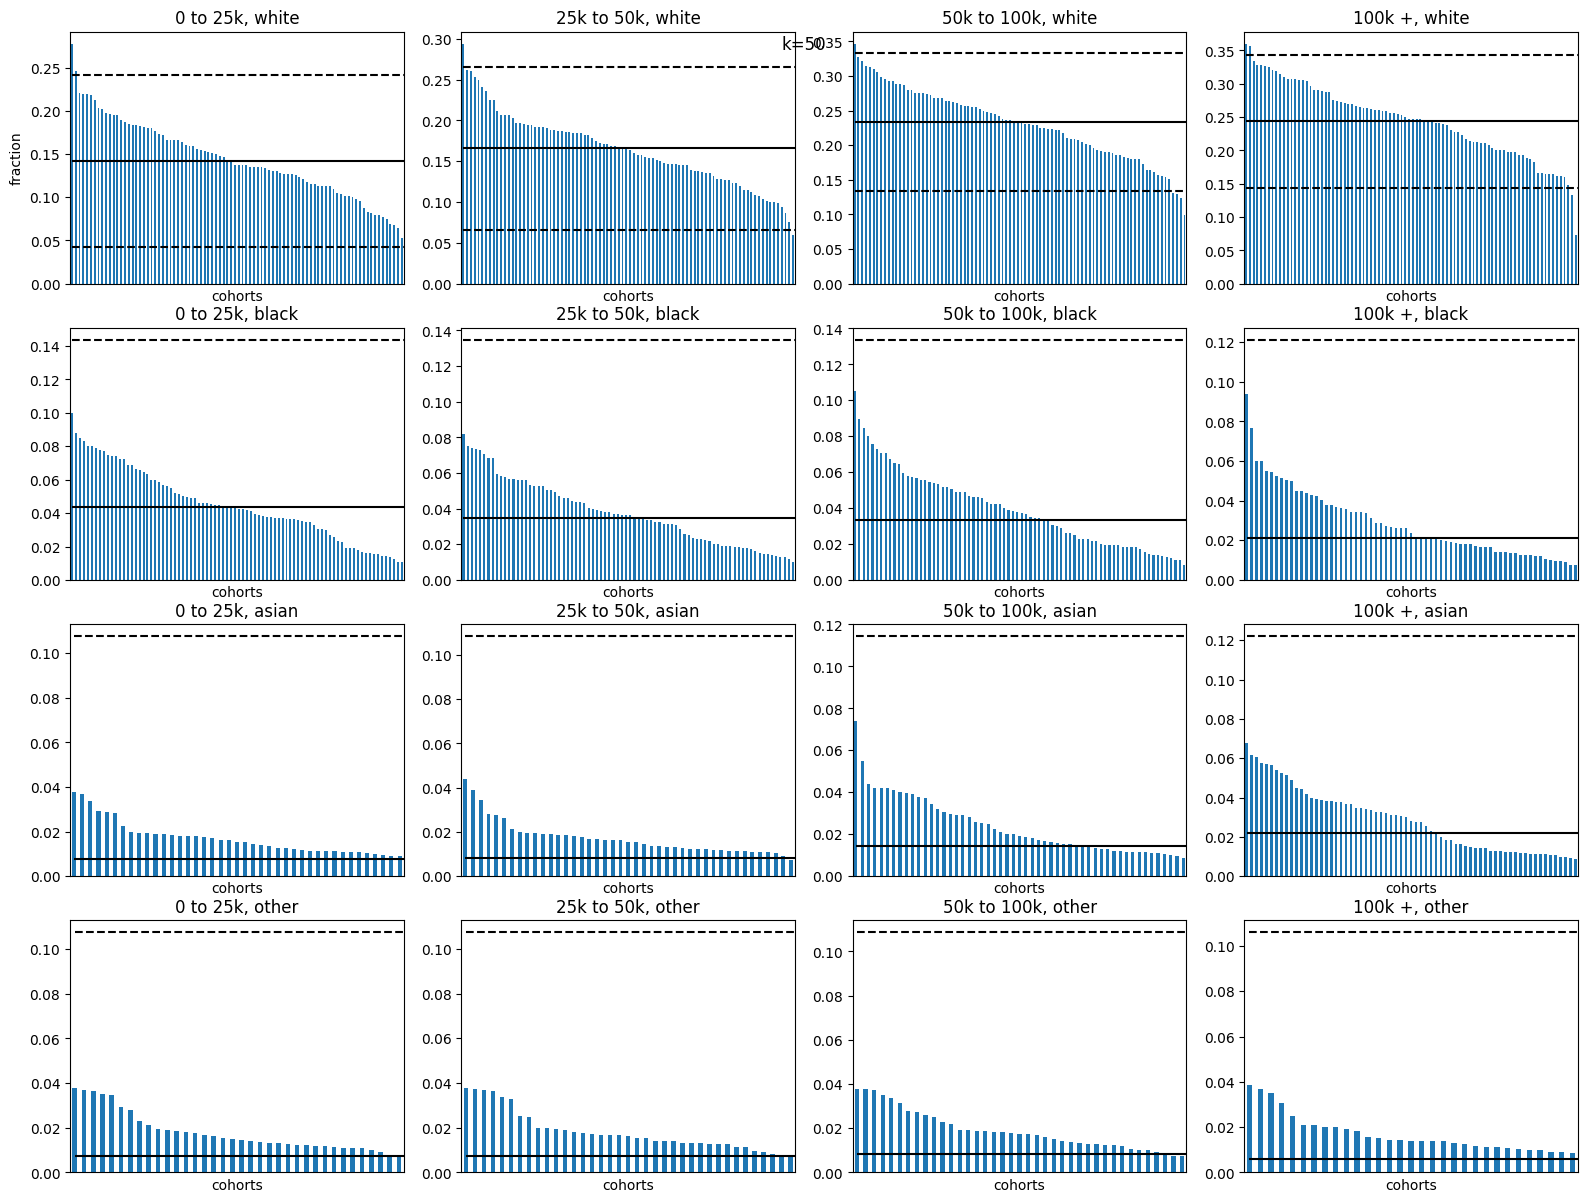


k=60 ---------------------------

68 total cohorts


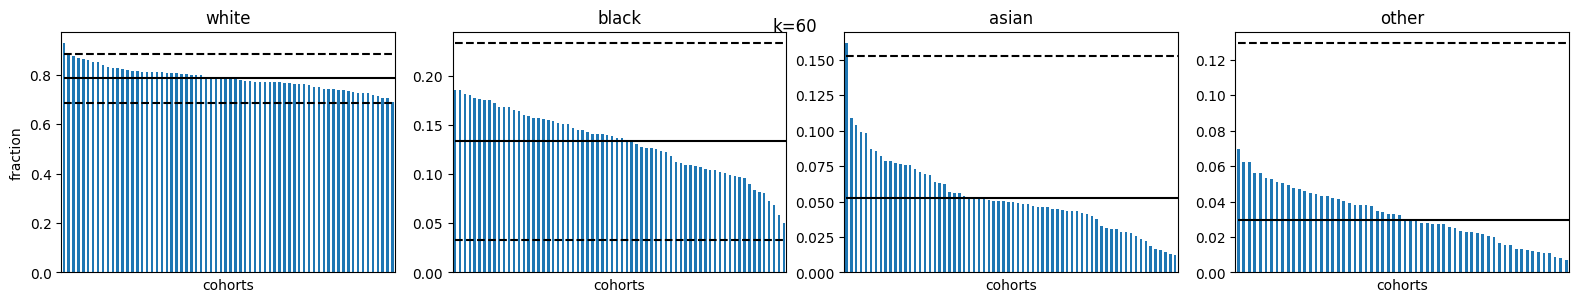

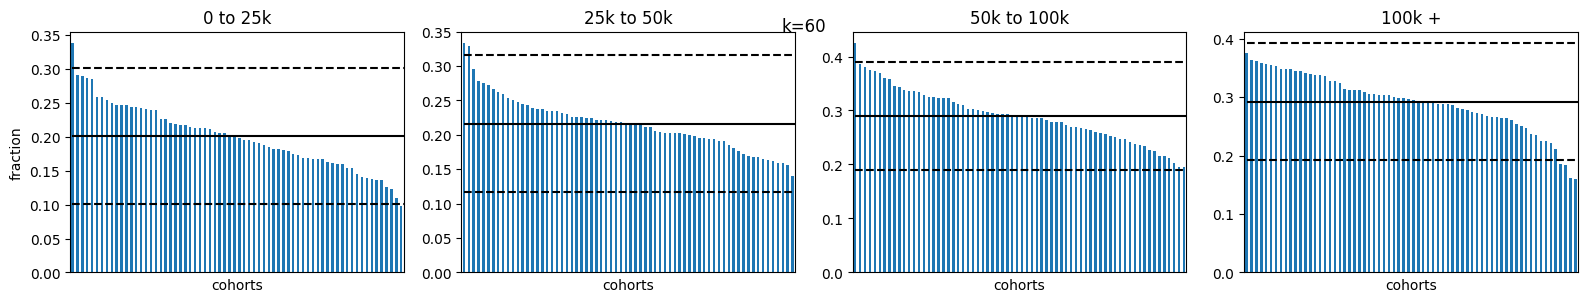

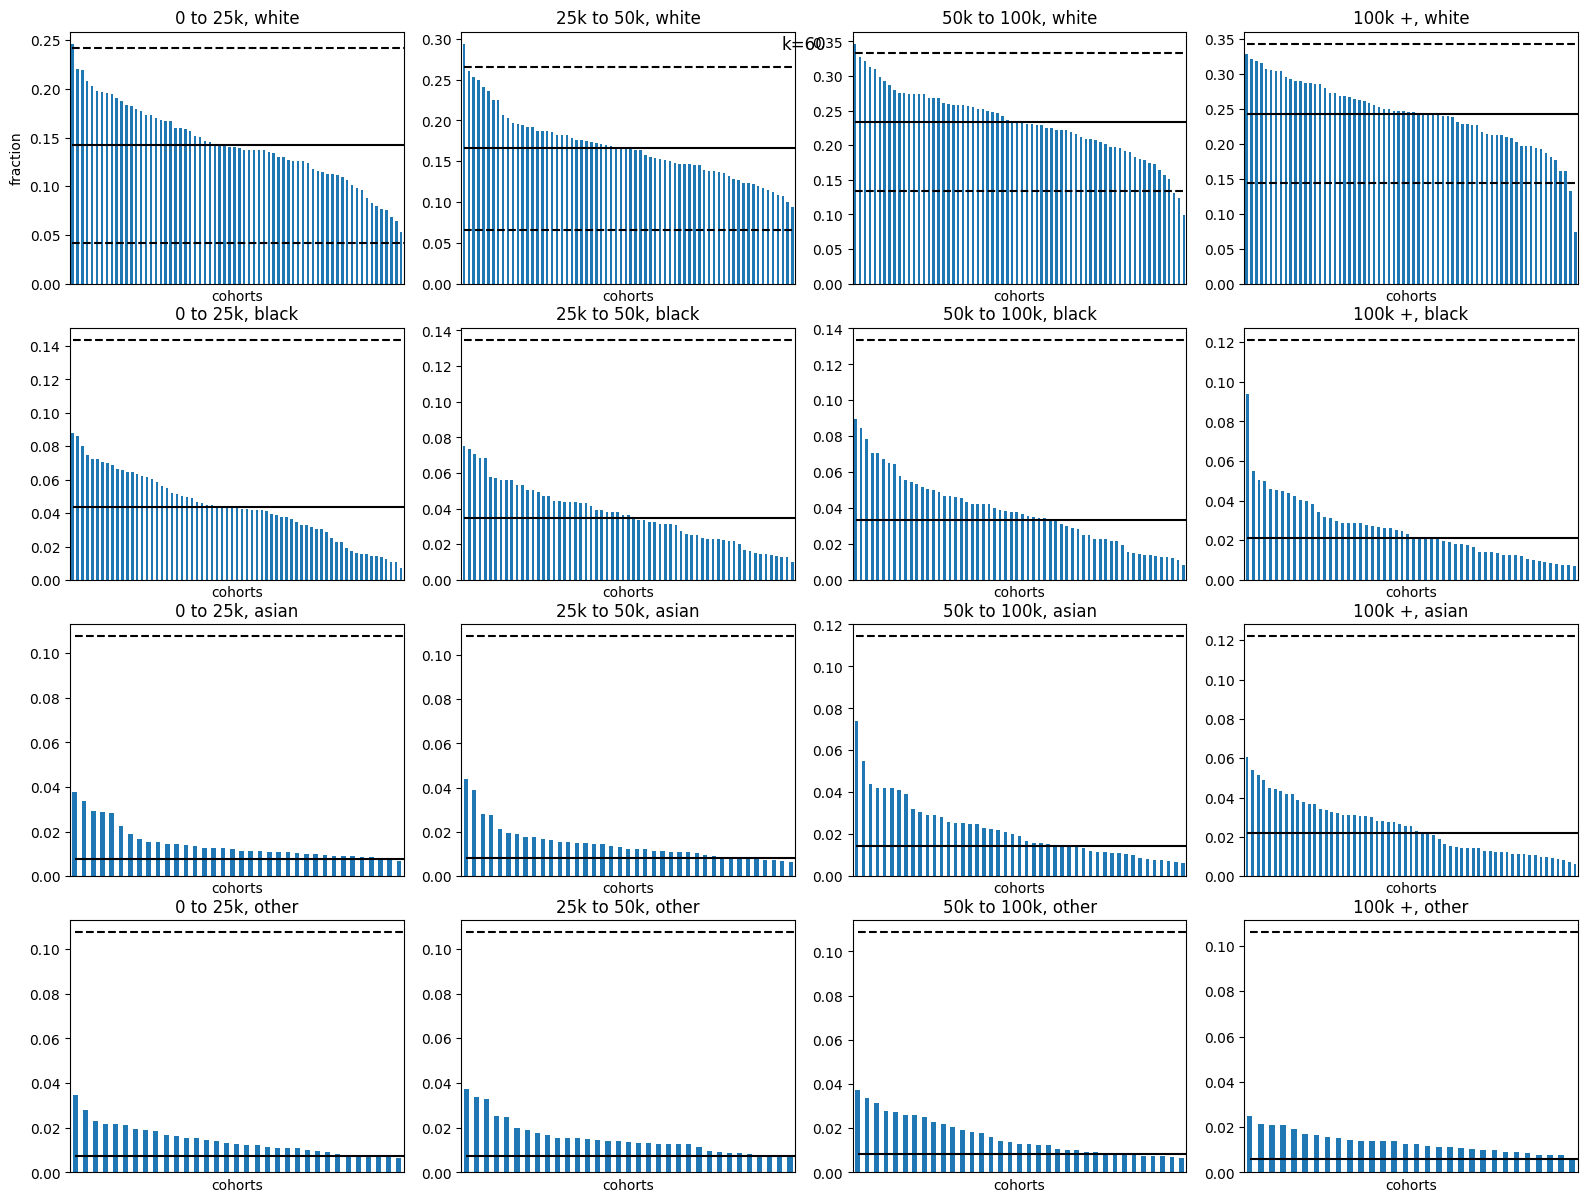


k=70 ---------------------------

60 total cohorts


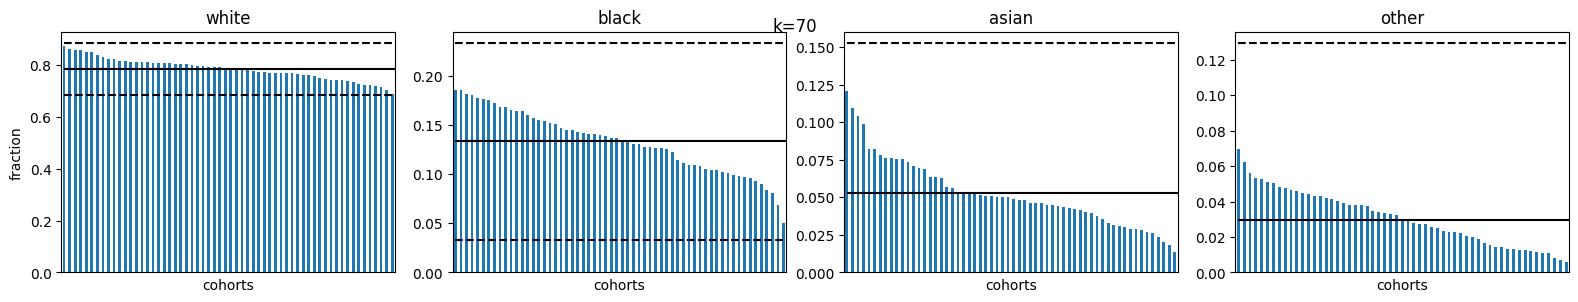

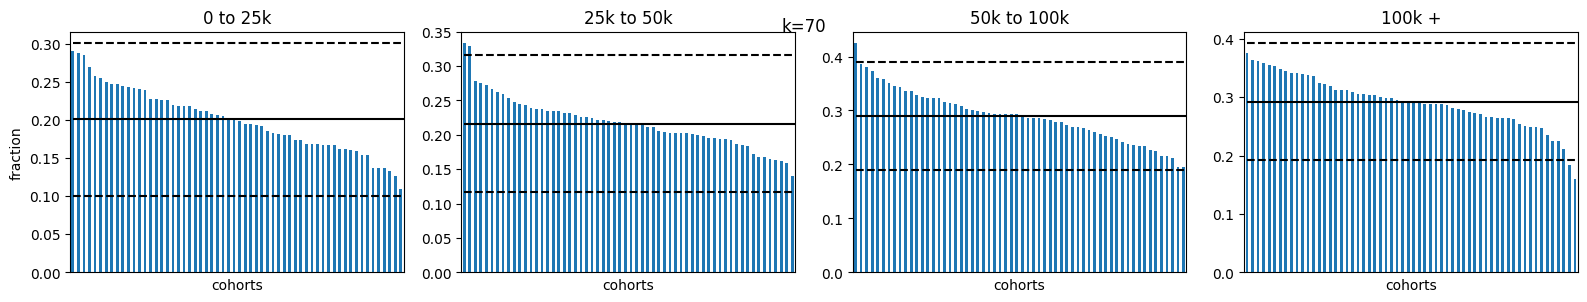

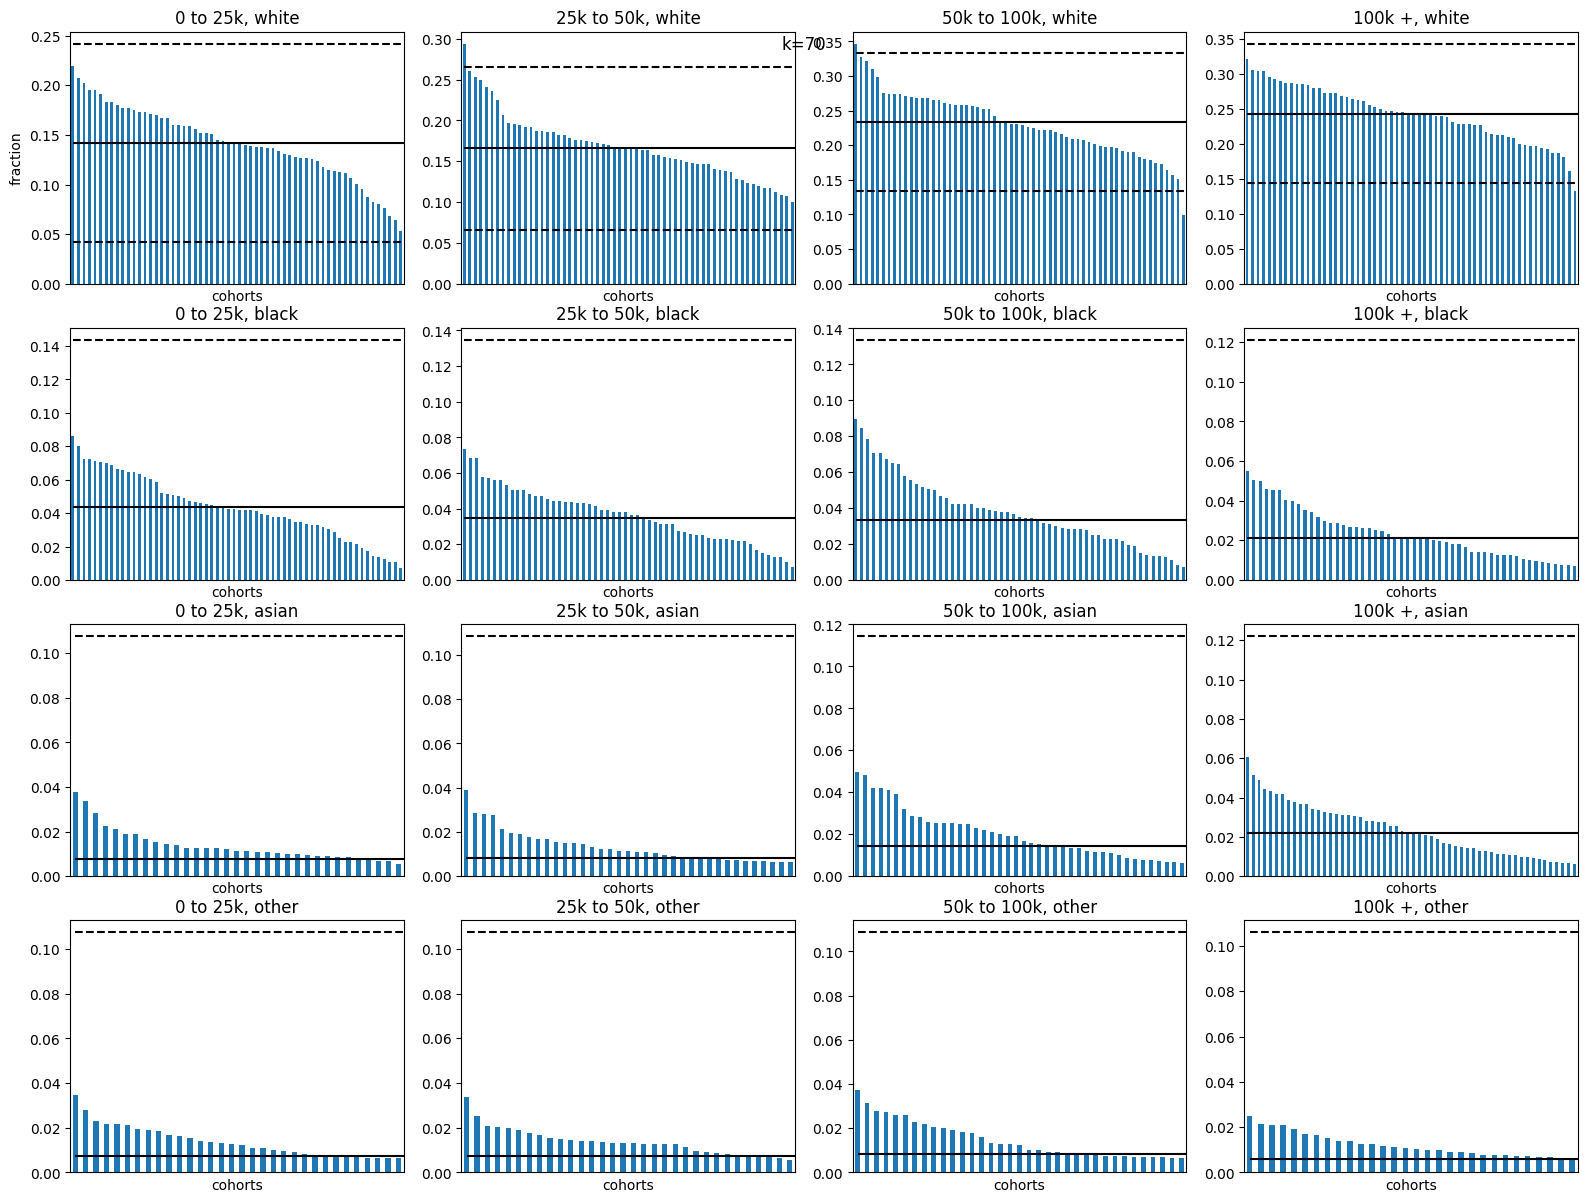


k=80 ---------------------------

50 total cohorts


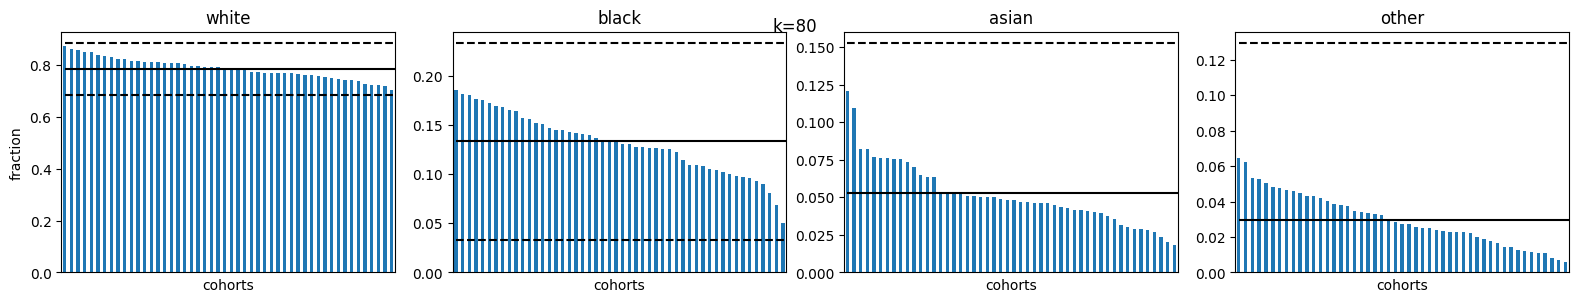

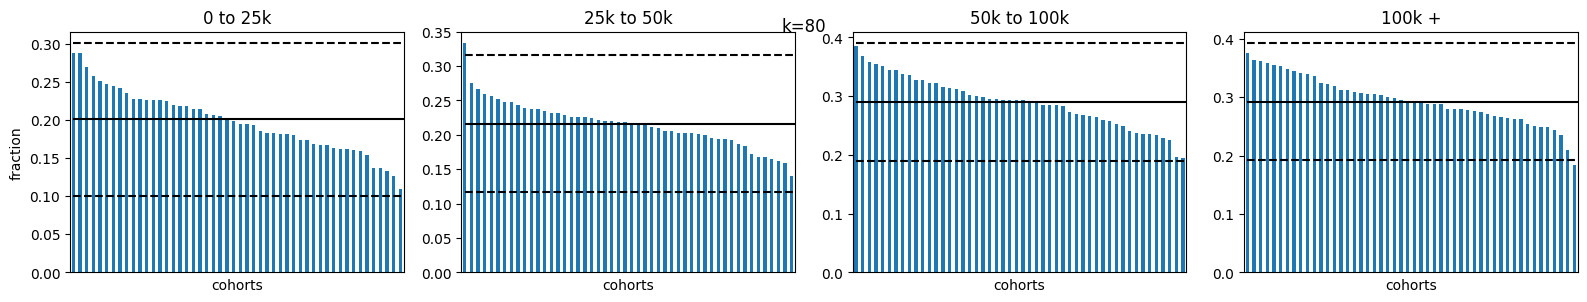

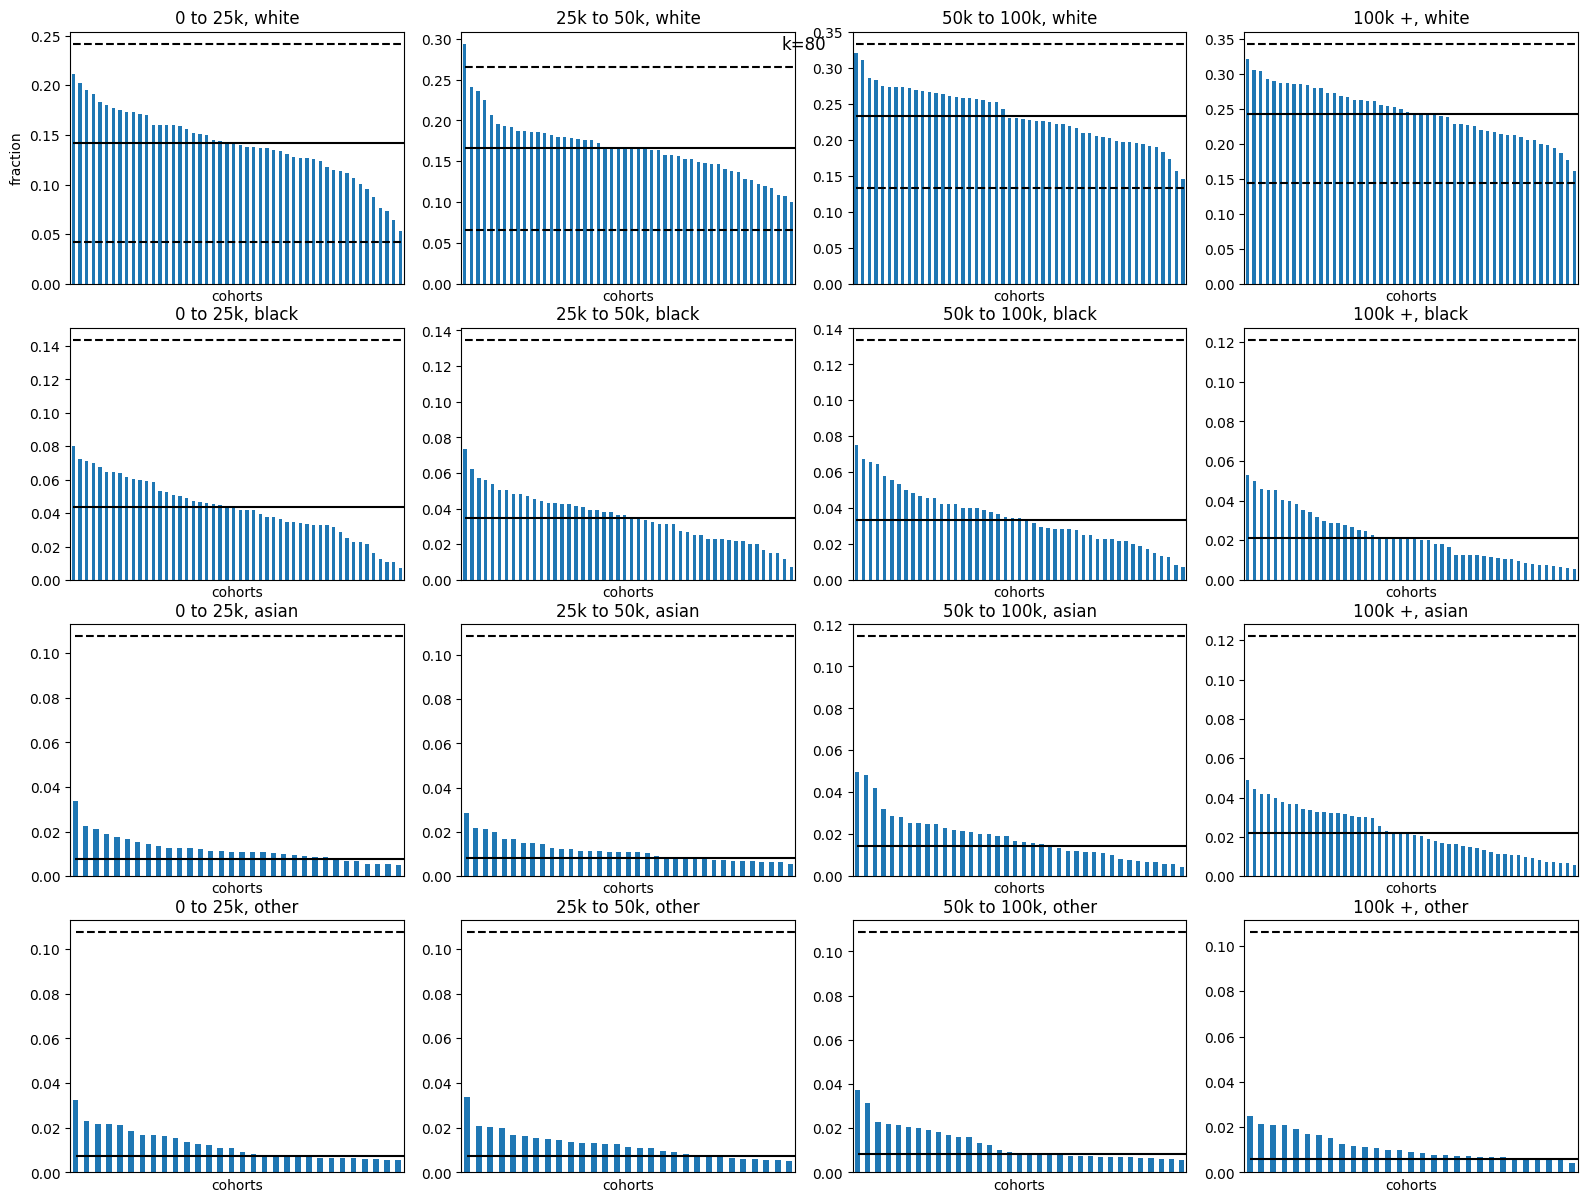


k=90 ---------------------------

46 total cohorts


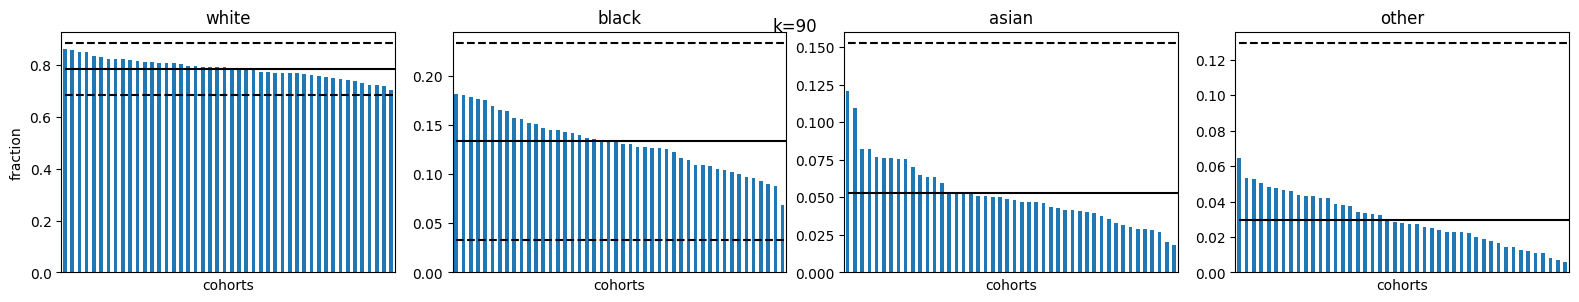

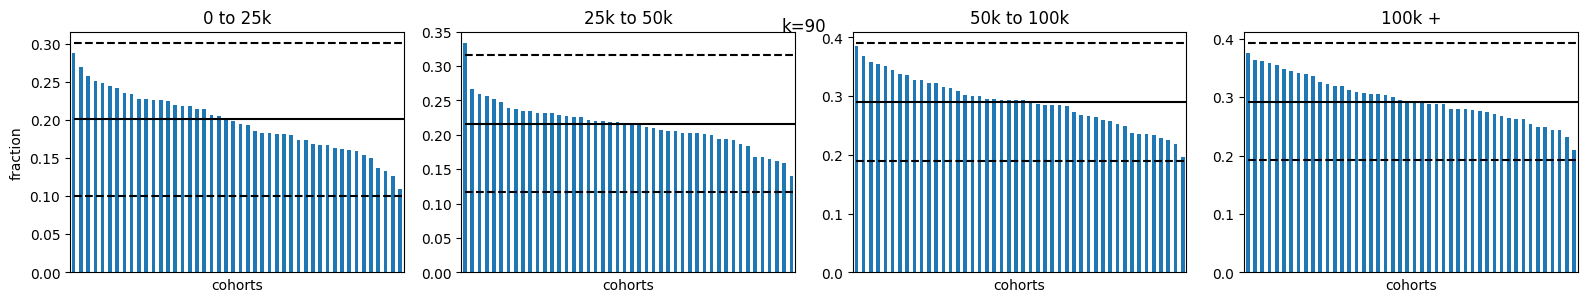

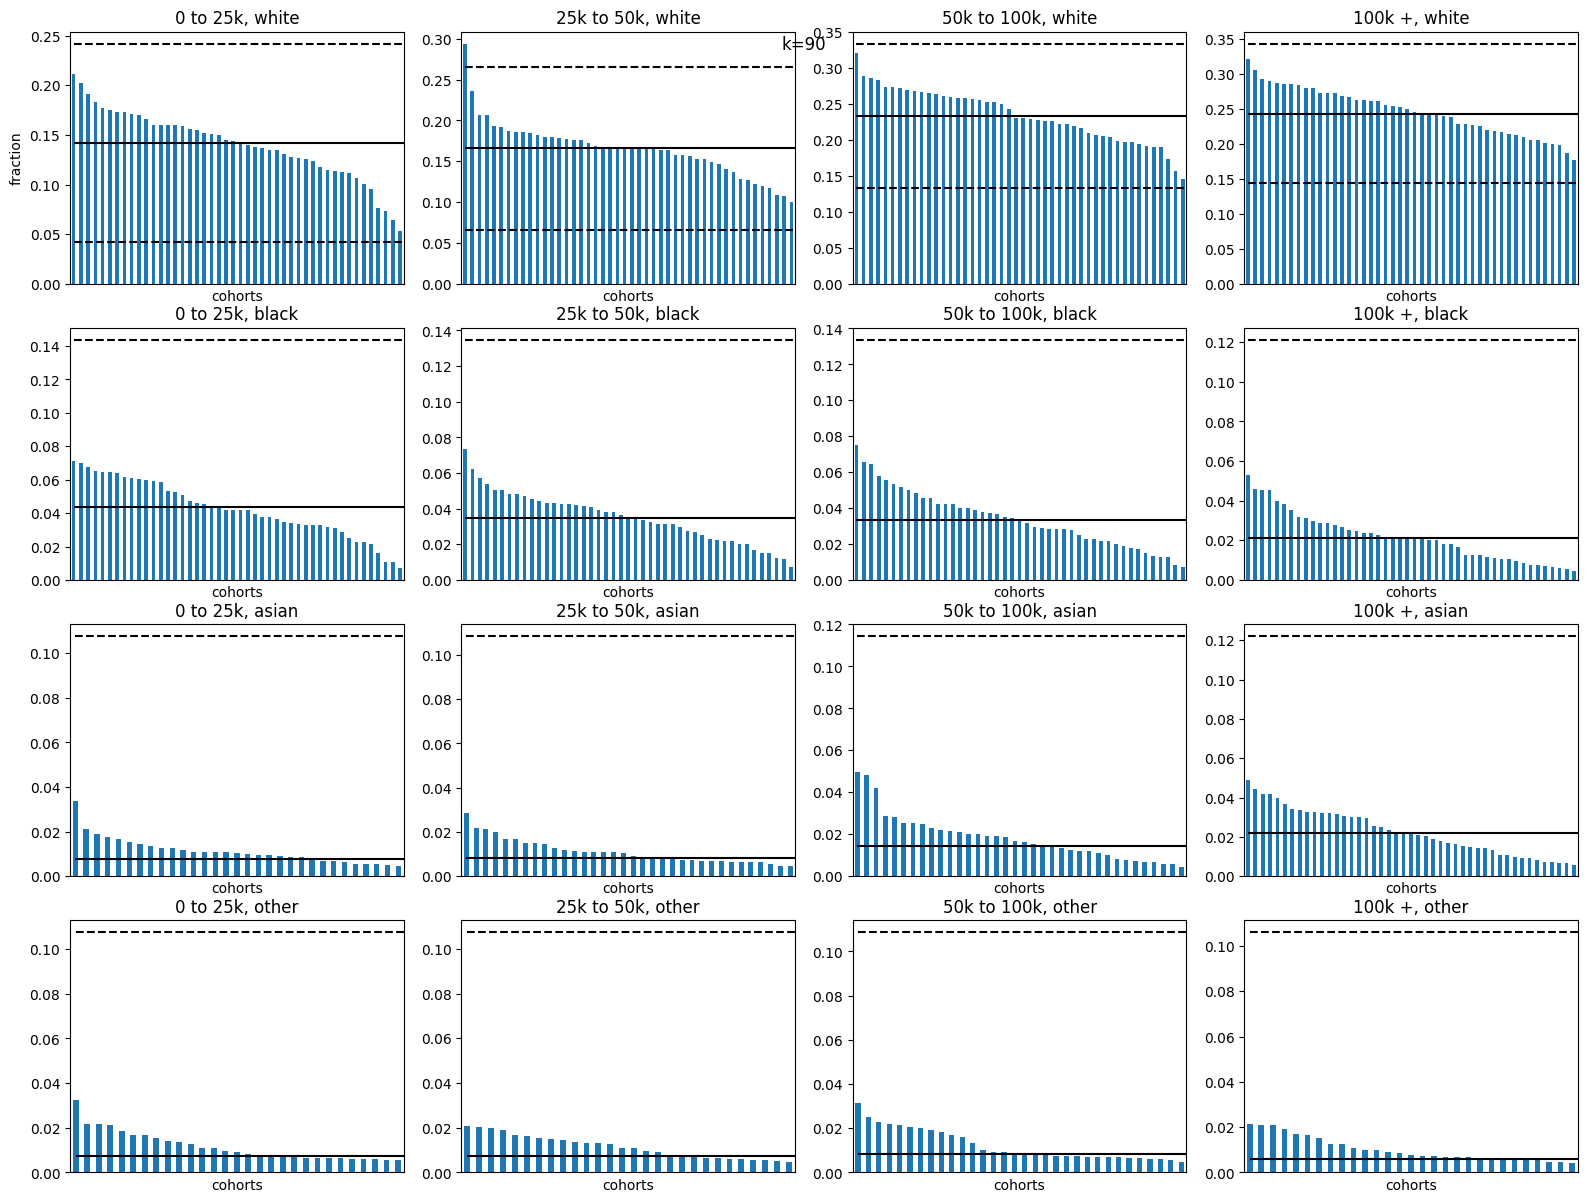


k=100 ---------------------------

41 total cohorts


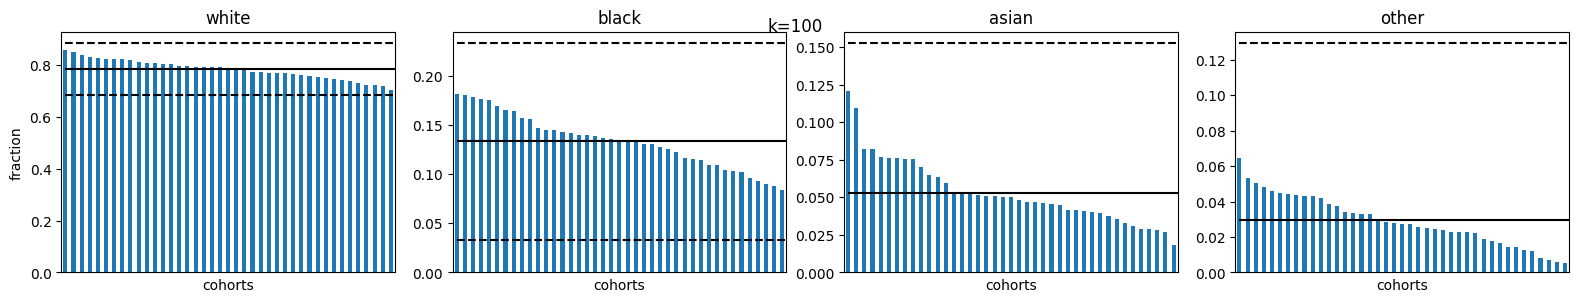

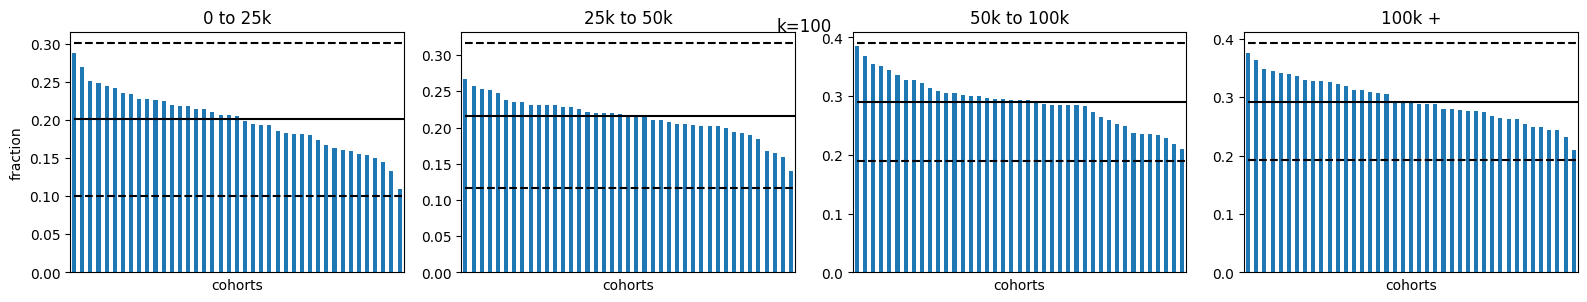

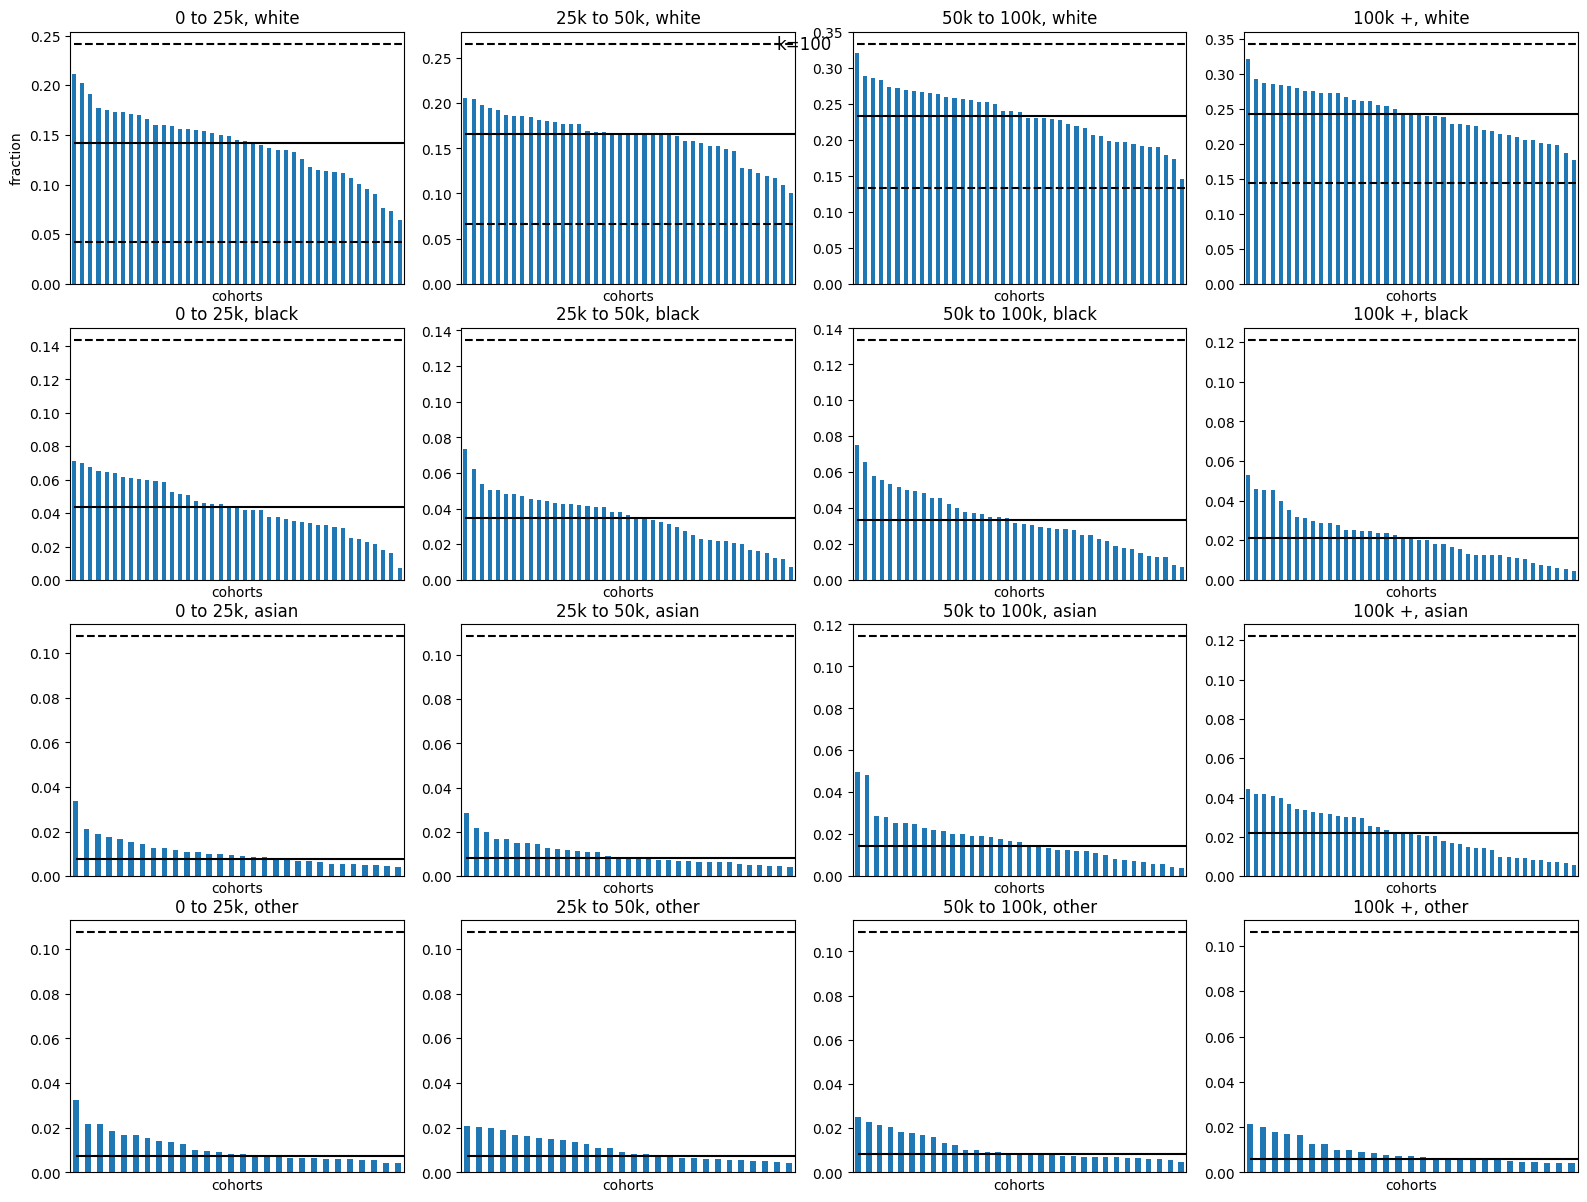

In [131]:
k_values = [20, 30, 40, 50, 60, 70, 80, 90, 100]

for k in k_values:
    print('\nk=%s ---------------------------\n' % k)
    cohorts_dict = prefixLSH.get_cohorts_dict(panel_df.simhash.astype(int), min_k=k)
    panel_df['cohort'] = panel_df.simhash.map(cohorts_dict)
    print('%s total cohorts' % panel_df.cohort.nunique())
    _ = plot_cohort_demo_fractions(panel_df, 'racial_background', race_values, suptitle='k=%s'%k)
    _ = plot_cohort_demo_fractions(panel_df, 'household_income', hi_values, suptitle='k=%s'%k)
    _ = plot_cohort_demo_fractions(panel_df, 'stratify', hi_race_values, suptitle='k=%s'%k)

Smaller sizes of k have higher amounts of variation.

## Testing the impact of larger panels

Here we assume weeks are independent samples and combine panels across weeks.

For each week, we randomly sample a panel to create a panel with data sampled across W (W=52?) weeks.

In [165]:
random.choice([1,2,3])

1

In [173]:
panels = []

W = 52
weeks = range(1, W+1)
for w in weeks:
    w_panels = all_panels_df[all_panels_df.week==w]
    # we sampled 10 panels per week
    assert(w_panels.panel_id.nunique() == 10)
    panel_id = random.choice(w_panels.panel_id.unique())
    #print('week %s panel id: %s' % (w, panel_id))
    panels += [all_panels_df[all_panels_df.panel_id==panel_id]]
    
assert(len(panels)==len(weeks))
combo_panel = pd.concat(panels)
assert(combo_panel.week.nunique()==W)
combo_panel.head(3)

,machine_id,week,n_domains,household_income,racial_background,stratify,panel_id,simhash,cohort
990627,222165143,1,63,1.0,1.0,"1.0, 1.0",157,752291308703513,67.0
990628,177372396,1,90,1.0,1.0,"1.0, 1.0",157,942032520589064,89.0
990629,225488908,1,58,1.0,1.0,"1.0, 1.0",157,168064150081251,14.0



k=50 ---------------------------

4222 total cohorts


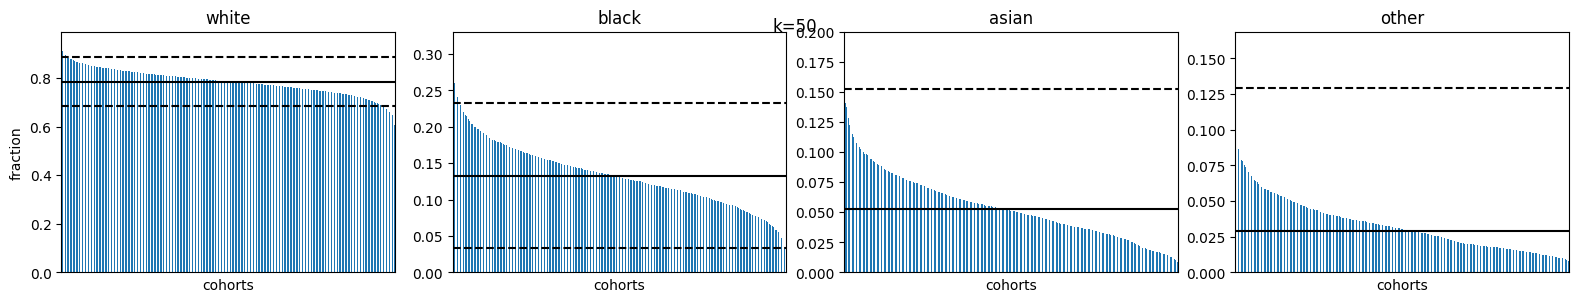

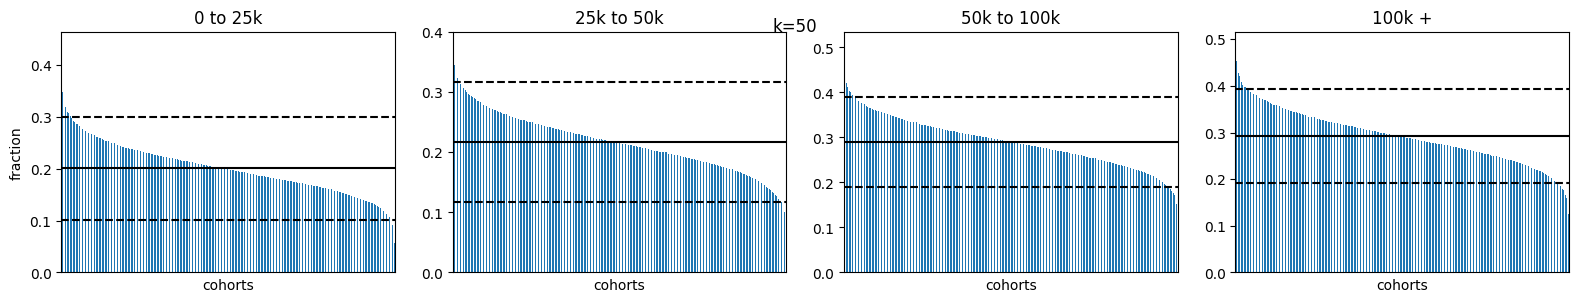

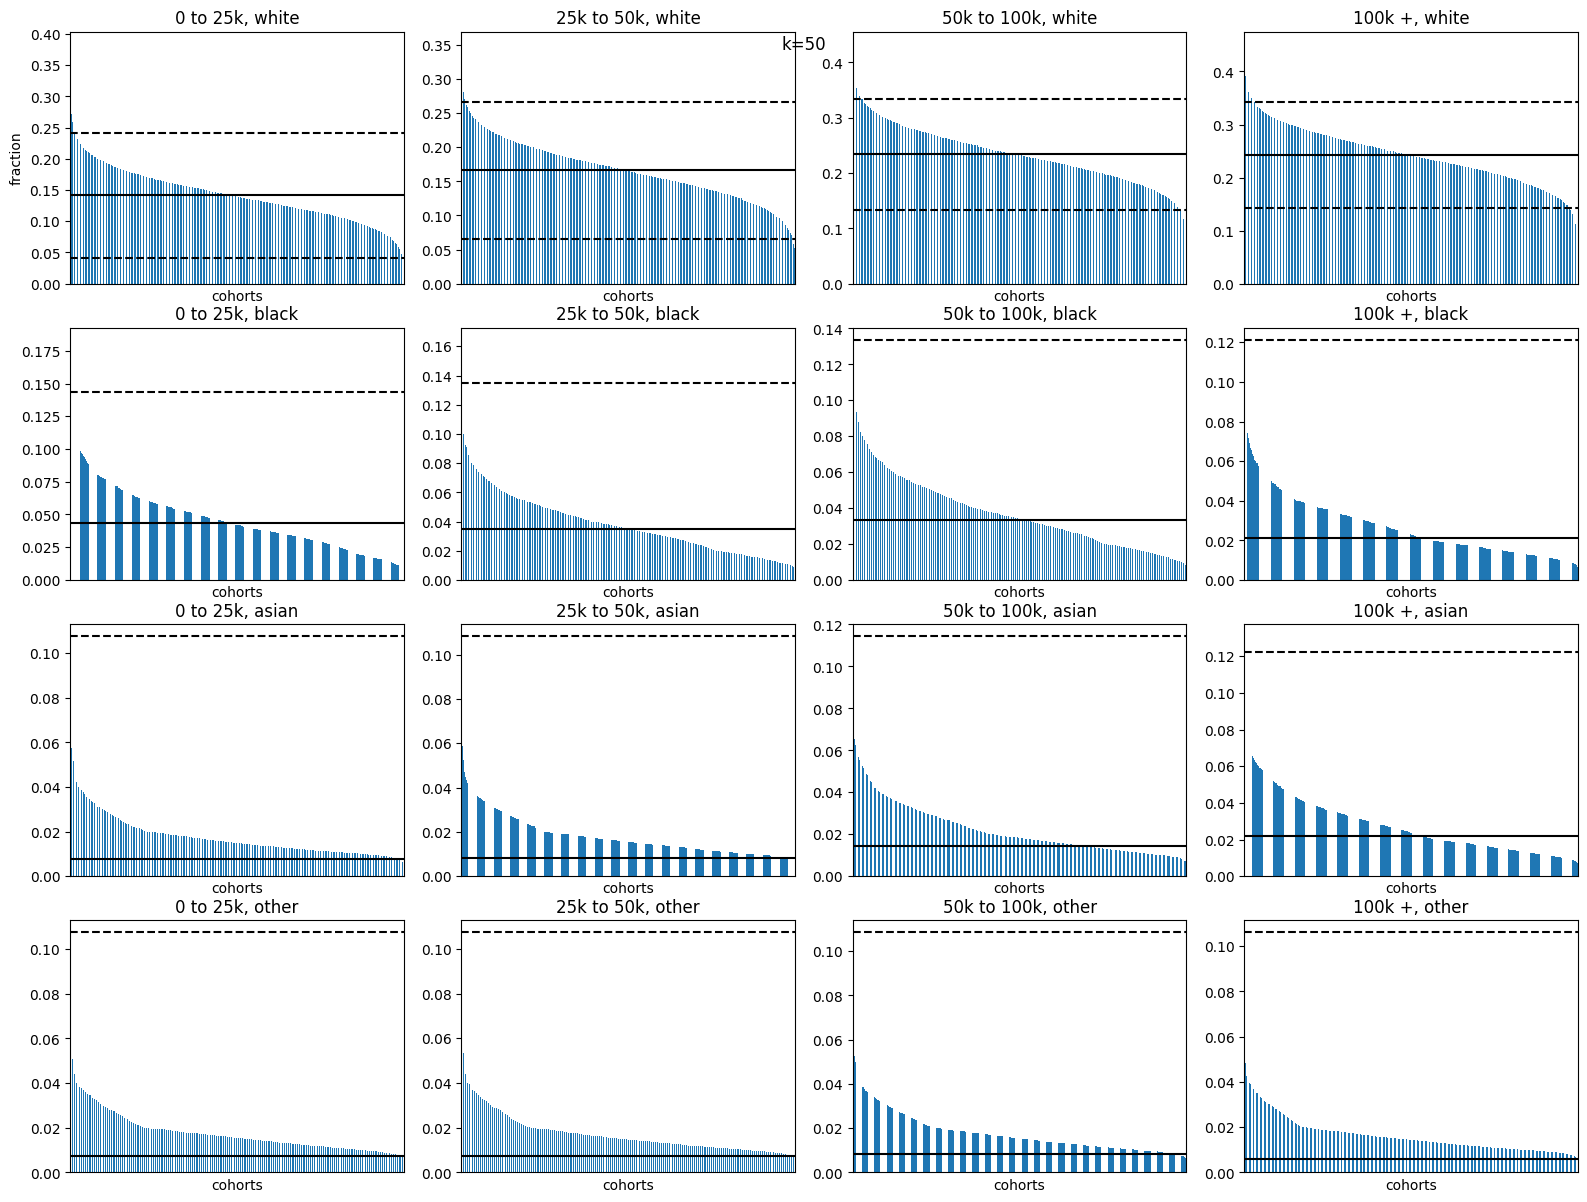


k=100 ---------------------------

1998 total cohorts


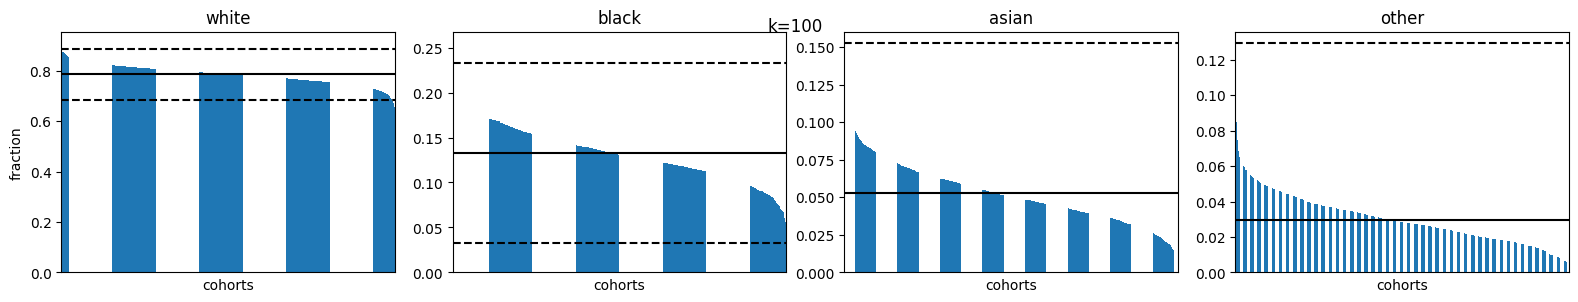

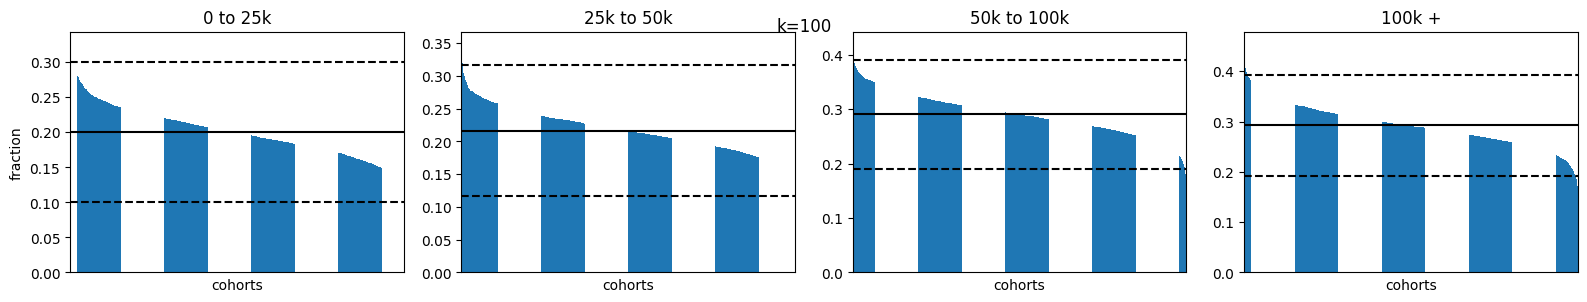

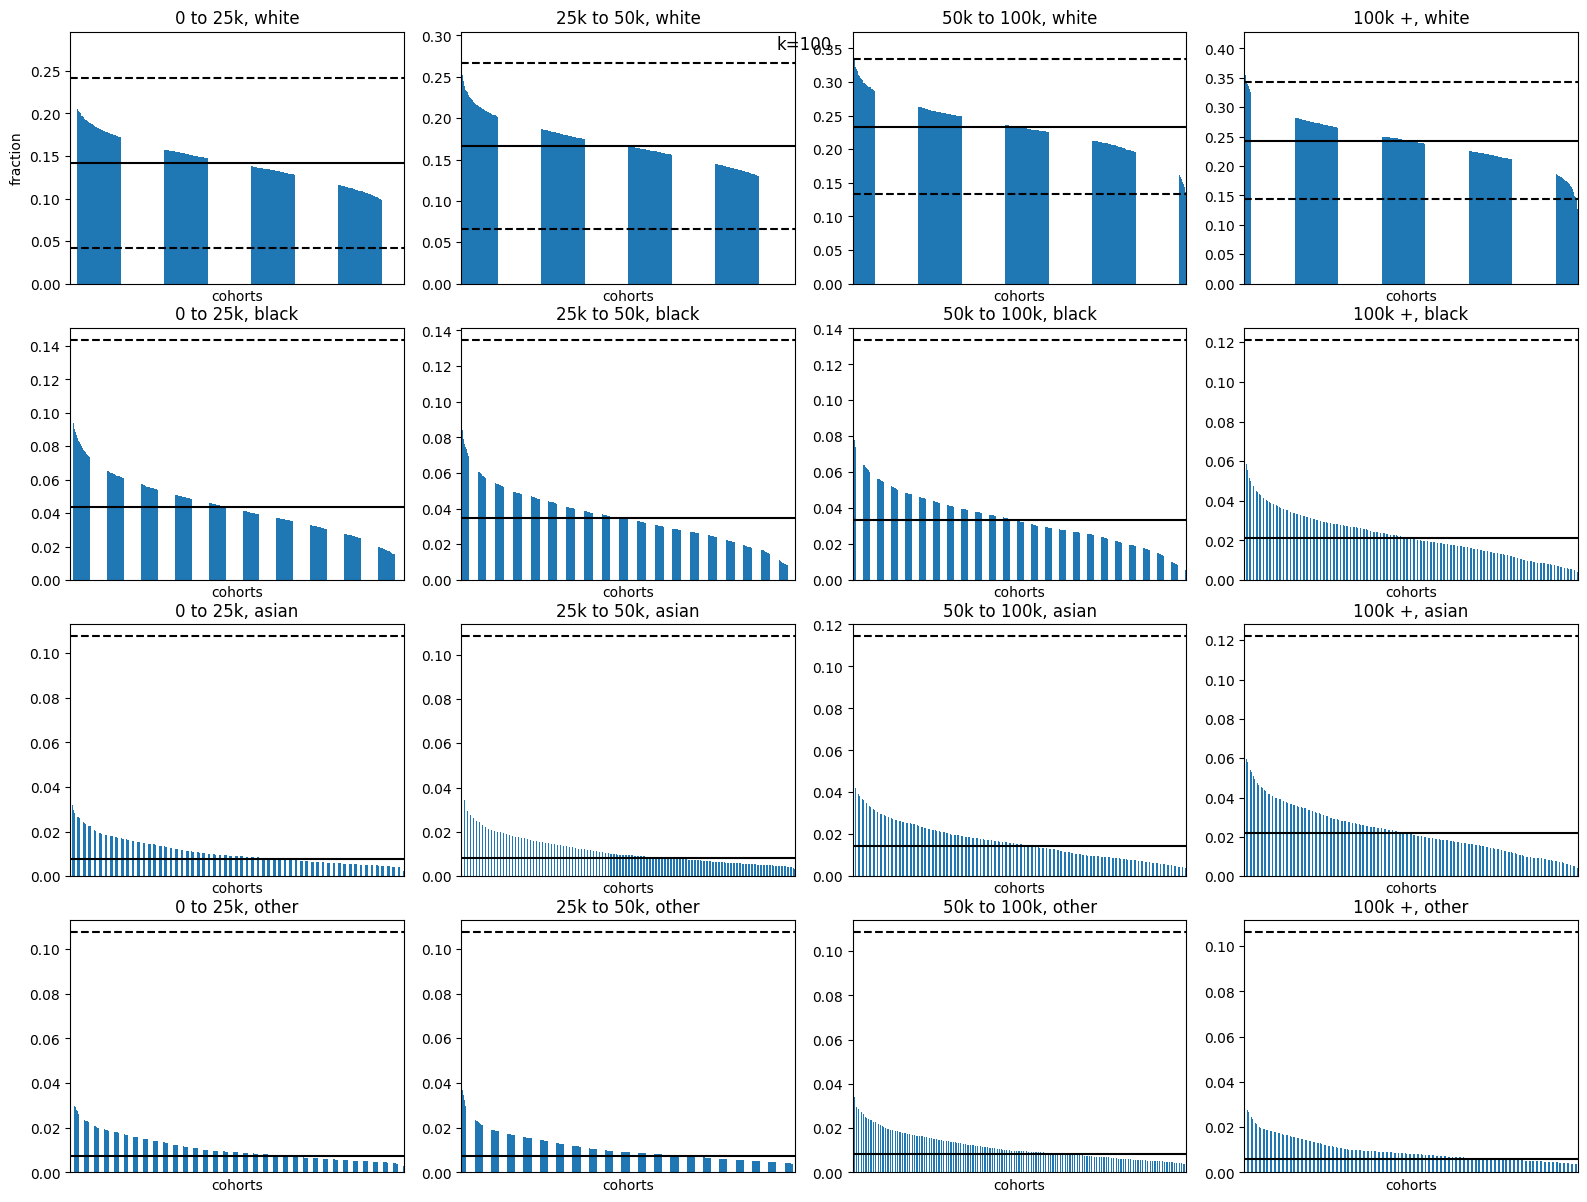


k=200 ---------------------------

1038 total cohorts


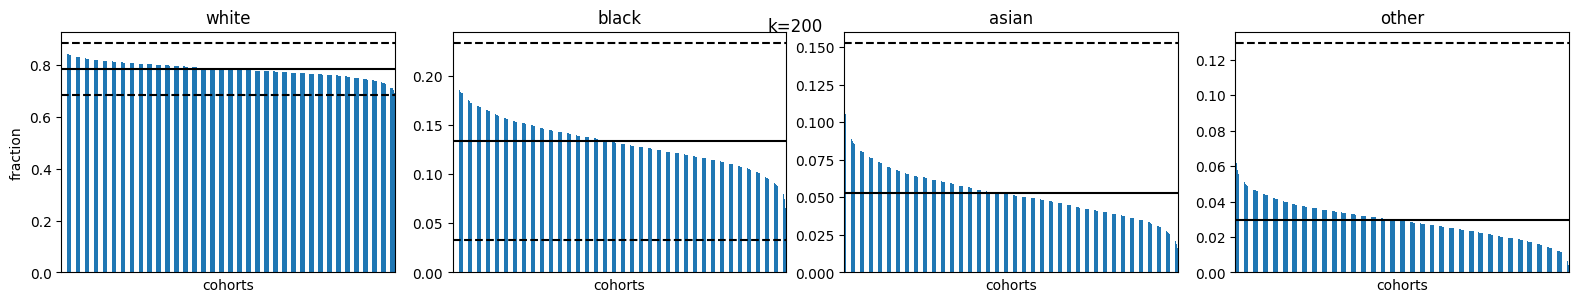

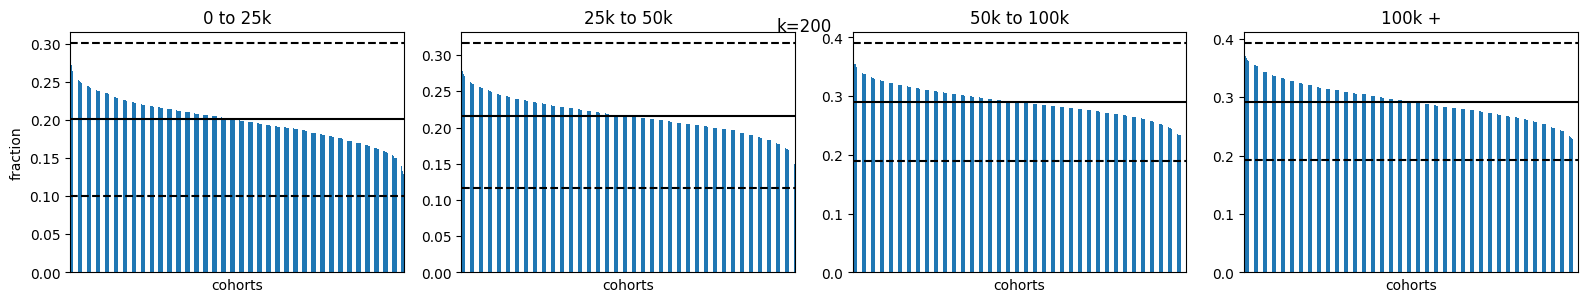

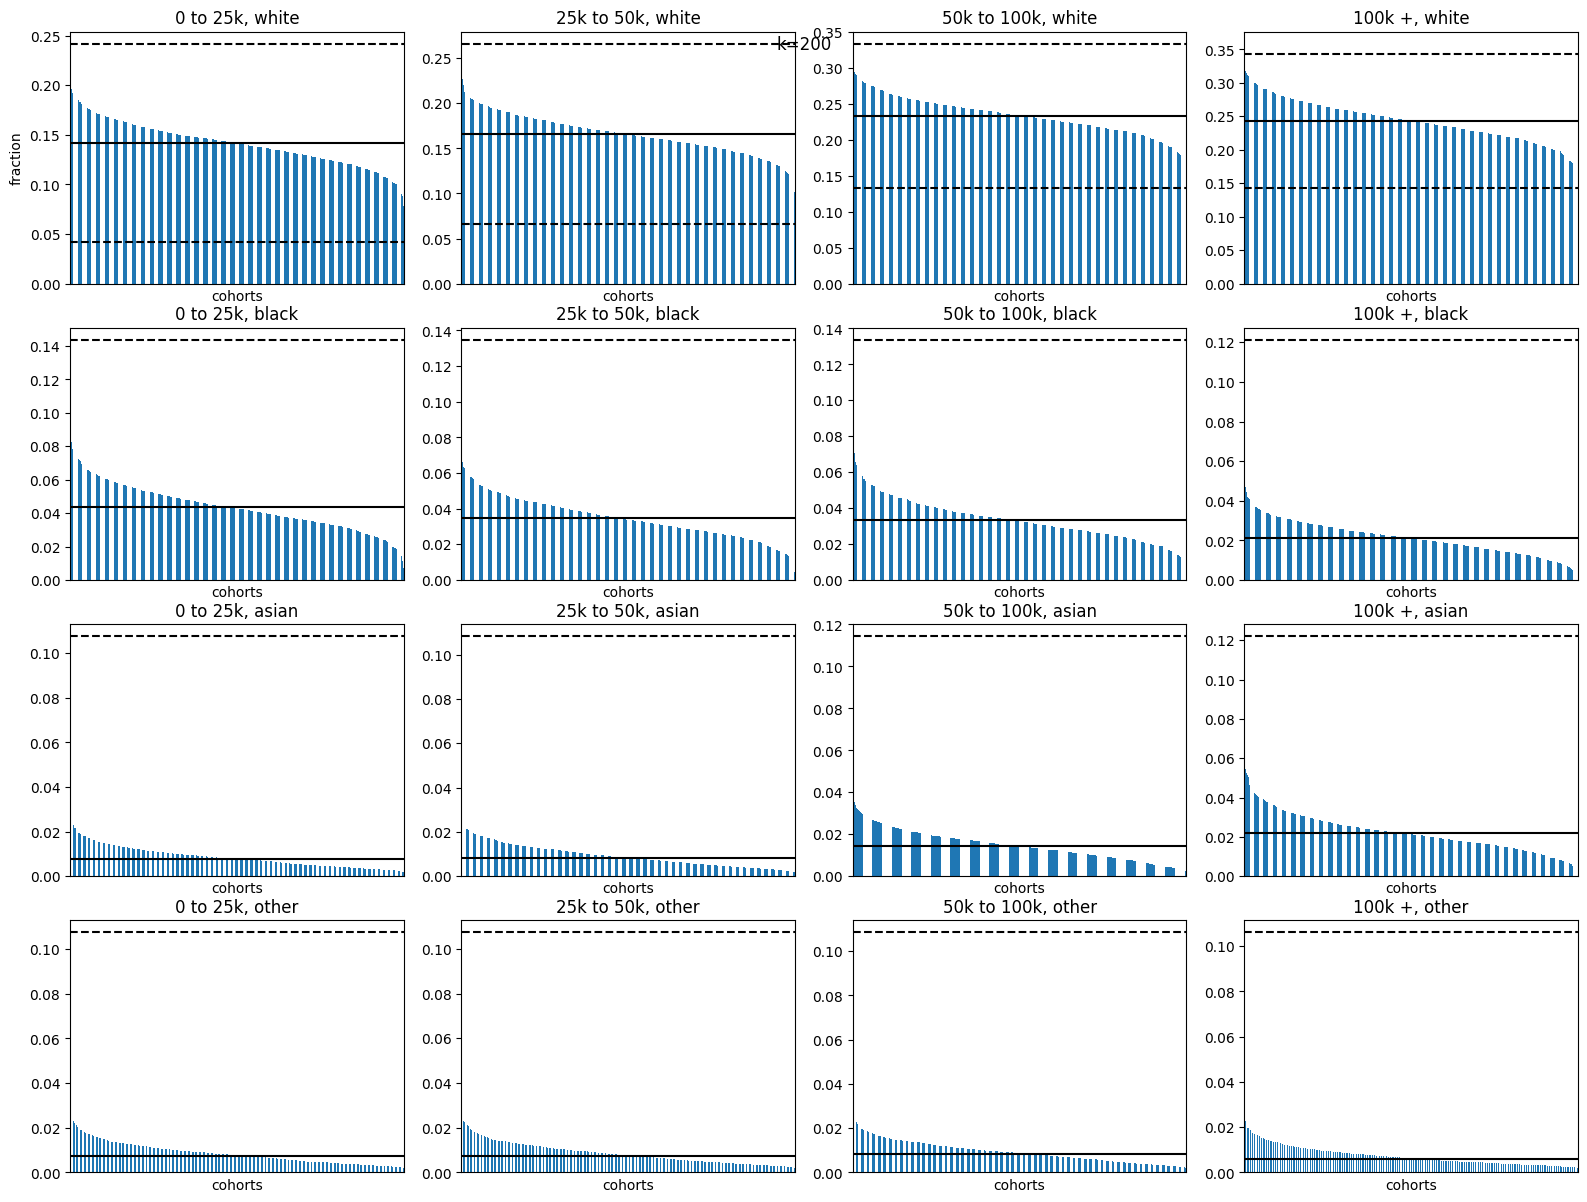


k=400 ---------------------------

524 total cohorts


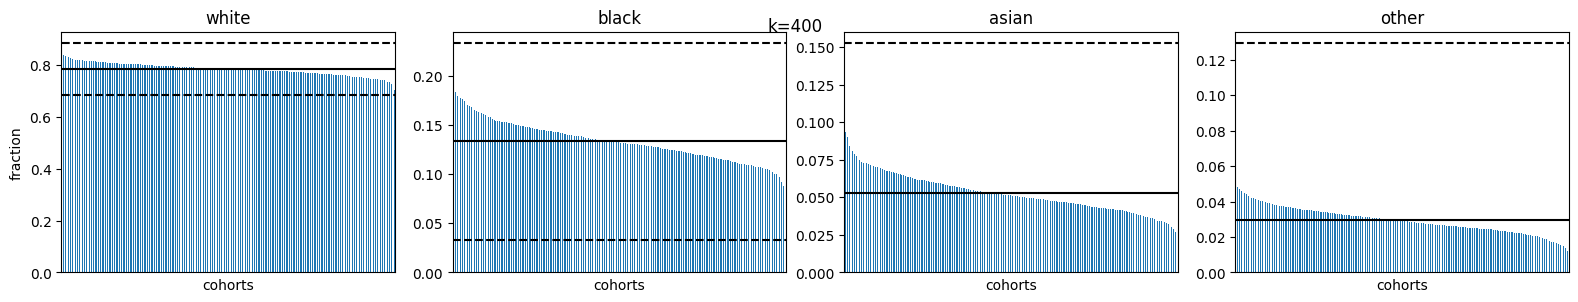

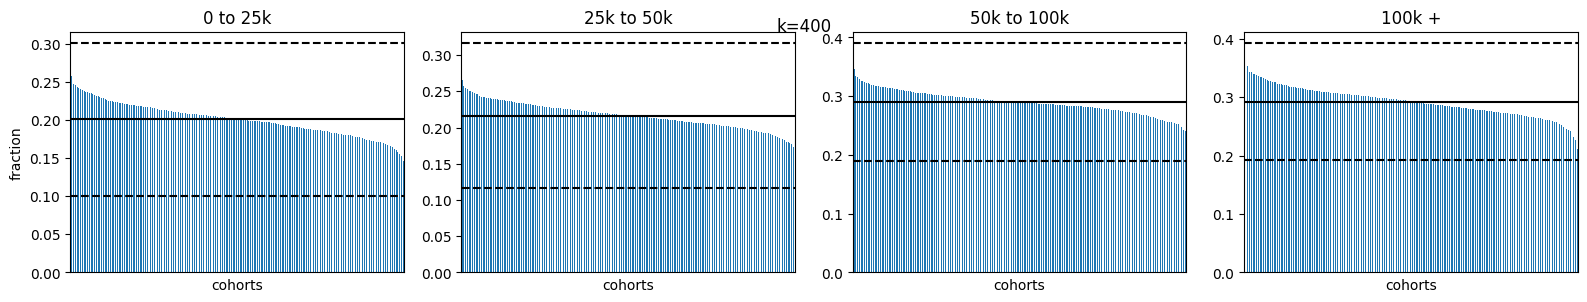

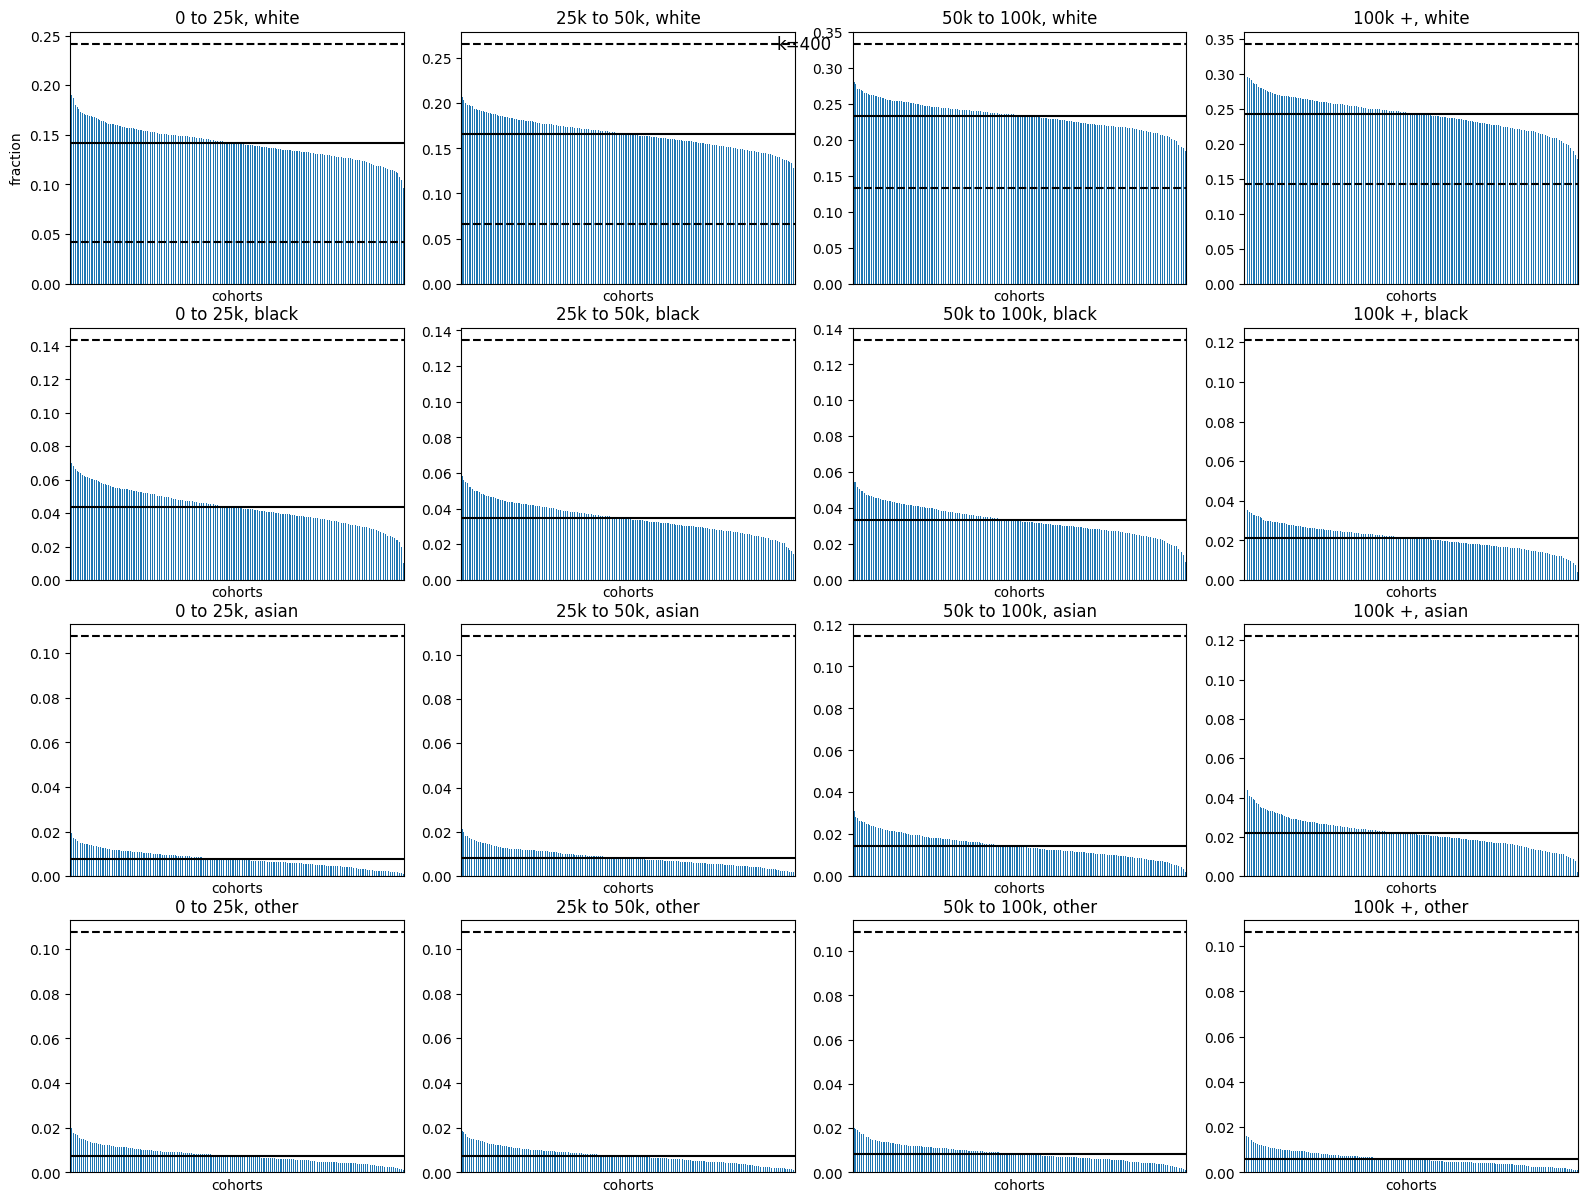


k=800 ---------------------------

253 total cohorts


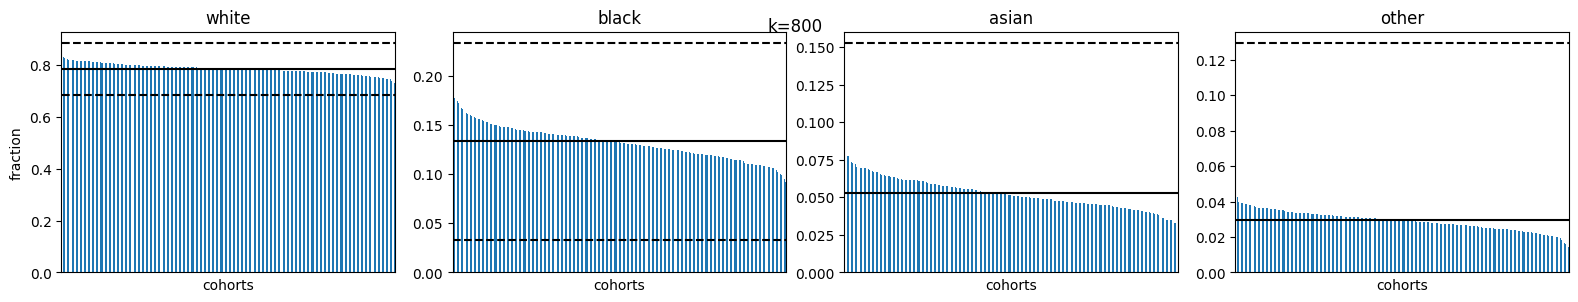

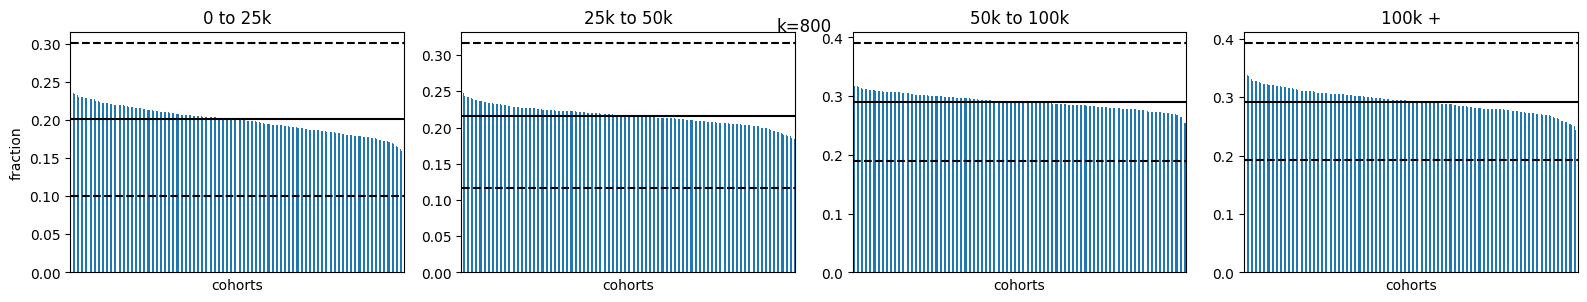

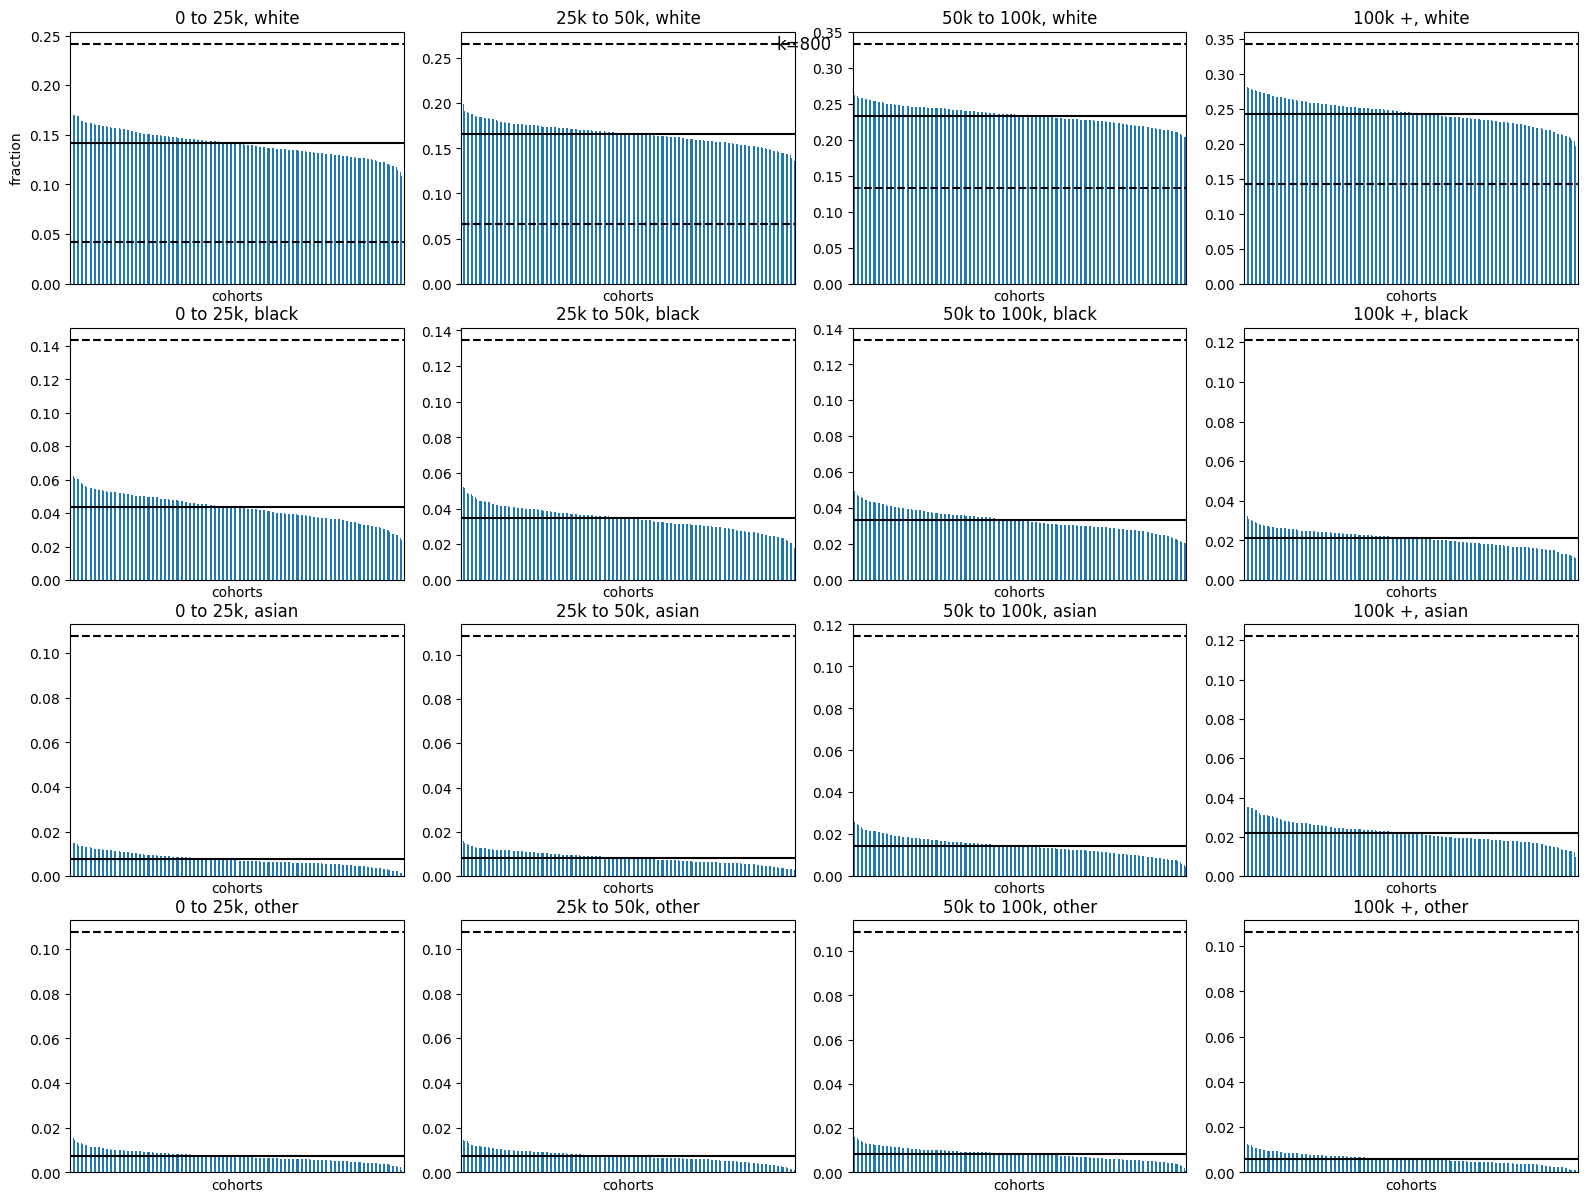


k=1000 ---------------------------

211 total cohorts


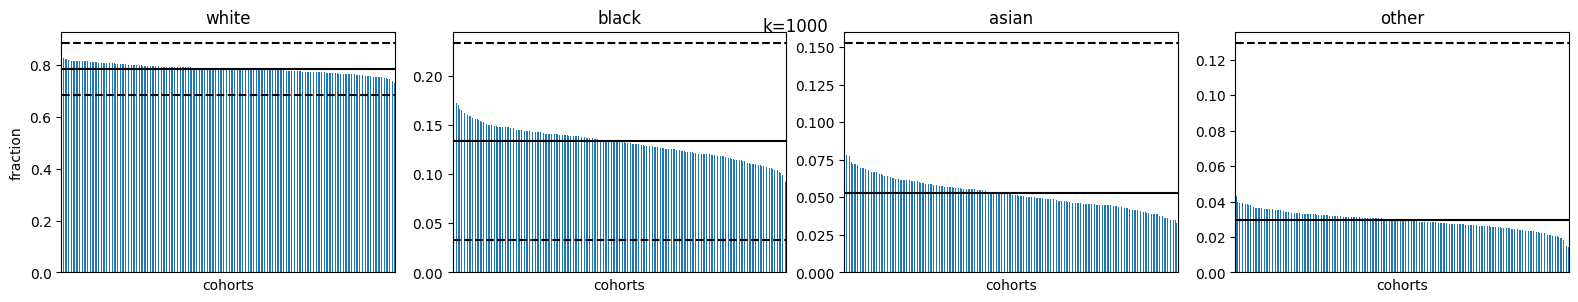

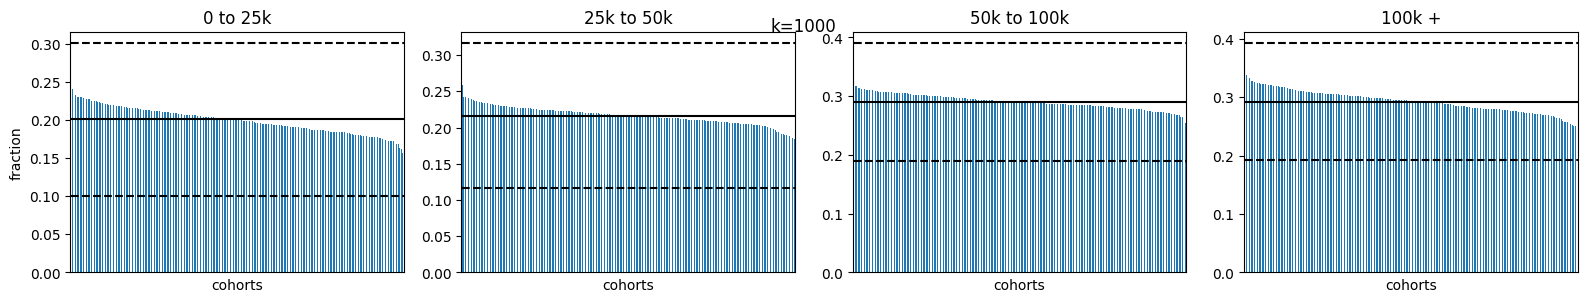

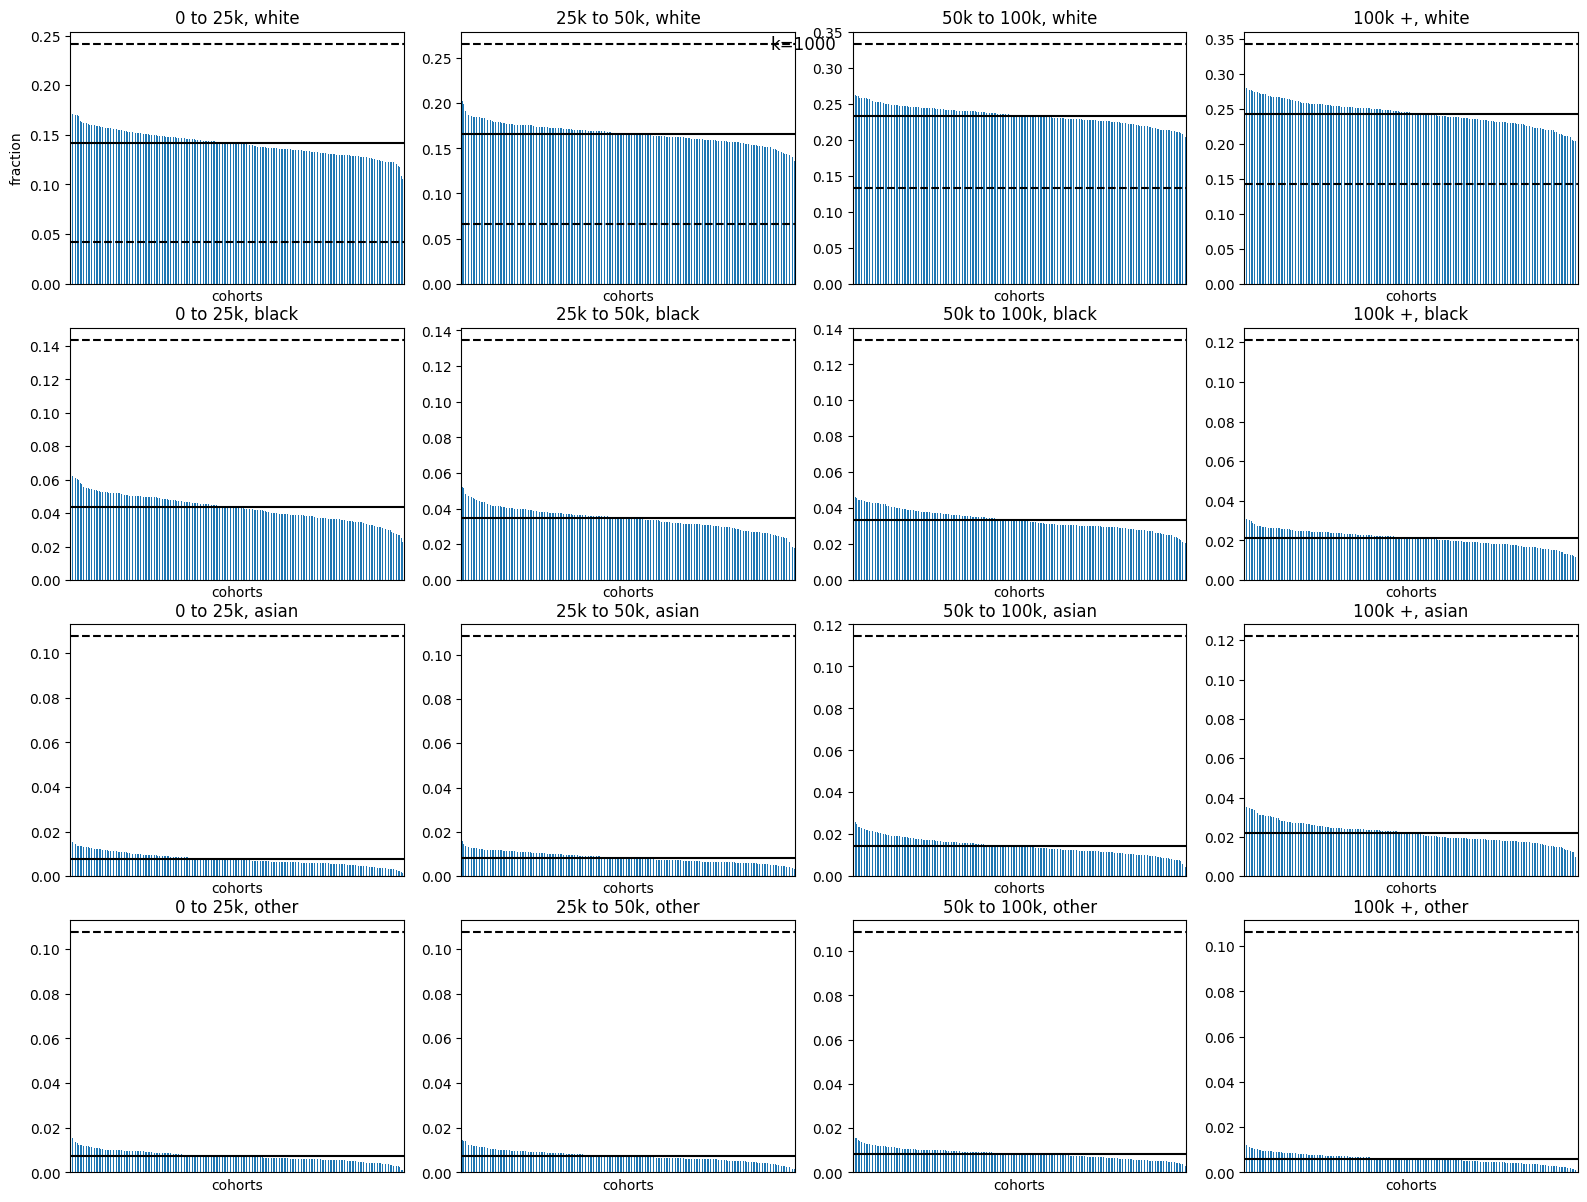

In [175]:
panel_df = combo_panel
k_values = [50, 100, 200, 400, 800, 1000]

for k in k_values:
    print('\nk=%s ---------------------------\n' % k)
    cohorts_dict = prefixLSH.get_cohorts_dict(panel_df.simhash.astype(int), min_k=k)
    panel_df['cohort'] = panel_df.simhash.map(cohorts_dict)
    print('%s total cohorts' % panel_df.cohort.nunique())
    _ = plot_cohort_demo_fractions(panel_df, 'racial_background', race_values, suptitle='k=%s'%k)
    _ = plot_cohort_demo_fractions(panel_df, 'household_income', hi_values, suptitle='k=%s'%k)
    _ = plot_cohort_demo_fractions(panel_df, 'stratify', hi_race_values, suptitle='k=%s'%k)